In [1]:
from dotenv import load_dotenv
import os
import wandb
import tarfile
import os
import shutil

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

from collections import namedtuple

In [2]:
# Load .env file
load_dotenv()

# Access the API key
# api_key = os.getenv("WANDB_API_KEY")
api_key = "4140c08ae9644450d5f09dbdff386b71e689b04c"
wandb.login(key=api_key)

api = wandb.Api(timeout=60)

entity = "j4b"        # Your WandB username or team name
project = "rl-battery-management" # Your WandB project name
run_id = "9et6b3zy" # 7a9k98t4 "f8l4u7x4" # "waj0fjc3"  9et6b3zy  prhn0gl1     # ID of the specific run 

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: janik-bischoff (j4b). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\zm0714\_netrc


In [3]:
# 20cs no_charge_in_breaks: 5ci1627k
# 4cs: smng8nfs
# 20cs charge_in_breaks (eval only): 5qdjkxob
# 20cs charge_in_breaks (train): q7y9vy3q
# Specify your project and run ID
# tpt: [0, 2, 4,..., 12] ept: 10: 2qemex9x

# Retrieve the run object
run = api.run(f"{entity}/{project}/runs/{run_id}")

In [4]:
n_cs = 3
n_partitions = 14
tar_name = 'experiment_data3'
root_dir = f'./result_data_charging_wepa/charging_strat_comp'
root_dir_extraction = f'{root_dir}/result_data_remote3'

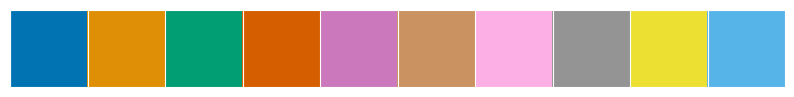

In [5]:
pal = sns.color_palette("colorblind")
sns.palplot(pal)

In [6]:
sns.set_style("whitegrid")
sns.set_context("talk")
# 
# hex_colors = ['#144246',
#               #'#69657e',
#               '#338470',
#               '#a6874e',
#               #'#FFFF33', '#FFD801', '#FFDF00',
#               '#f2be25', '#e8dcb9']
# pal = sns.color_palette(hex_colors, desat=1)
# sns.palplot(pal)

In [12]:
shortnames = {
    'COL': 'COL',
    ' COL': 'COL',
    ' CTD': 'CTD',
    ' CTNR': 'CTNR',
    ' SL': 'SL',
    ' SLO': 'SLO',
    'RND':'RND',
    'allOrdersPopularity_future_z2': 'AOPF2',
    'allOrdersPopularity_future_z3': 'AOPF3',
    'allOrdersPopularity_future_z5': 'AOPF5',
    'allOrdersPopularity_past_z2': 'AOPP2',
    'allOrdersPopularity_past_z3': 'AOPP3',
    'allOrdersPopularity_past_z5': 'AOPP5',
    'classBasedCycleTime_z2': 'CBCT2',
    'classBasedCycleTime_z3': 'CBCT3',
    'classBasedCycleTime_z5': 'CBCT5',
    'retrievalPopularity_future_z2': 'ROPF2',
    'retrievalPopularity_future_z3': 'ROPF3',
    'retrievalPopularity_future_z5': 'ROPF5',
    'retrievalPopularity_past_z2': 'ROPP2',
    'retrievalPopularity_past_z3': 'ROPP3',
    'retrievalPopularity_past_z5': 'ROPP5',
    'VeryGreedy COL': 'GCOL',
    'DQN': 'COL',
    'SAC': 'SAC'
}

In [7]:
def order_files(src_dir):
    files = os.listdir(src_dir)
    pbar = tqdm(total=len(files))
    for i in range(len(files)):
        f_name = files[i]
        print(f_name)
        if not f_name.endswith('.csv') or 'actions' in f_name:
            continue
        segs = f_name.split('_')
        pt = segs[1]
        charging_policy = segs[3]
        th = segs[4]
        name = segs[3]
        # new_name = shortnames[name]
        interrupted = segs[5]
        orders = f'{int(segs[-1].split(".")[0]):06}'
        tgt_dir = f'{src_dir}/partition_{pt}/{th}/{interrupted}/{name}/'
        if not os.path.exists(tgt_dir):
            os.makedirs(tgt_dir)
        shutil.move(f'{src_dir}/{f_name}',
                    f'{tgt_dir}/{orders}.csv')
        pbar.update(1)
order_files(root_dir)

  0%|          | 0/31 [00:00<?, ?it/s]

boxplot__kpi__average_service_time_ppo_rewards.png
boxplot__kpi__average_service_time_thresholds_per_week.png
boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png
boxplot__kpi__max_ret_buffer_per_week.png
boxplot__kpi__queued_retrieval_orders_ppo_rewards.png
boxplot__queued_retrieval_thresholds_vs_interrupt_per_week.png
constraints__avg_battery_level.png
constraints__kpi__average_service_time.png
constraints__n_queued_charging_events.png
constraints__n_queued_retrieval_orders.png
fill_level_weeks.png
full_run
kpi_retrieval_orders_service_time_vs_weeks.png
n_orders.png
partition_0
partition_1
partition_10
partition_11
partition_12
partition_13
partition_2
partition_3
partition_4
partition_5
partition_6
partition_7
partition_8
partition_9
ppo_ep_rewards.png
ppo_scaled_rewards.png
test


In [13]:
def load_storage_strategy_dataframe(data_root):
    n_zones = 3
    strategy_name = data_root.split('/')[4]
    interrupted = data_root.split('/')[5]
    go_charging = data_root.split('/')[6]
    # n_zones = int(strategy_name[-1]) if strategy_name[-1].isdigit() else 3
    if not os.path.exists(data_root):
        print(f"did not find path {data_root}; skipping...")
        return
    dfs = []
    csv_f_names = os.listdir(data_root)
    # pbar = tqdm(total=len(csv_f_names))
    print(f'Loading result files into dataframes for the '
          f'{strategy_name} simulation run...')
    for f_name in csv_f_names:
        if os.path.isdir(f'{data_root}/{f_name}') or f_name == '.DS_Store':
            #print(f'{data_root}/{f_name}')
            continue
        df_result_part = pd.read_csv(f'{data_root}/{f_name}', index_col=0)
        n_rows = df_result_part.shape[0]
        df_result_part['strategy_name'] = [f"{go_charging}_{strategy_name}_{interrupted}"] * n_rows
        df_result_part['n_zones'] = [n_zones] * n_rows
        df_result_part['interrupted'] = [interrupted] * n_rows
        df_result_part['go_charging'] = [go_charging] * n_rows

        dfs.append(df_result_part)
        # print(strategy_name, n_zones, order_set_nr)
        # pbar.update(1)
    strategy_df = pd.concat(dfs).reset_index(drop=True)
    strategy_df.name = f"{go_charging}_{strategy_name}_{interrupted}"
    return strategy_df

# dfs_d = dict({})
# n_agvs = 40
# for n_cs in range(1,9):
#     dfs_d[n_cs] = []
#     for shortname in shortnames.values():
#         df = load_storage_strategy_dataframe(
#             f'{root_dir}/n_agvs__{n_agvs}/n_cs__{n_cs}/{shortname}')
#         if df is not None:
#             dfs_d[n_cs].append(df)
dfs_d = dict({})
partitions = [i for i in range(n_partitions)]
thresholds = ["th30", "th40", "th50", "th60", "th70", "th80", "th90", "th100", "R1", "R2", "R3", "R4"]
interrupted = ["False", "True"]
go_charging = ["FixedCharge", "Fixed", "Opportunistic", "PPO"]
for pt in partitions:
    print(f"Loading partition {pt}")
    dfs_d[pt] = []
    for th in thresholds:
        for interrupt in interrupted:
            for strat in go_charging:
                path = f'{root_dir}/partition_{pt}/{th}/{interrupt}/{strat}'
                df = load_storage_strategy_dataframe(path)
                if df is not None:
                    dfs_d[pt].append(df)

Loading partition 0
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
did not find path ./result_data_charging_wepa/charging_strat_comp/partition_0/th30/False/PPO; skipping...
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
Loading result files into dataframes for the th30 simulation run...
did not find path ./result_data_charging_wepa/charging_strat_comp/partition_0/th30/True/PPO; skipping...
Loading result files into dataframes for the th40 simulation run...
Loading result files into dataframes for the th40 simulation run...
Loading result files into dataframes for the th40 simulation run...
did not find path ./result_data_charging_wepa/charging_strat_comp/partition_0/th40/False/PPO; skipping...
Loading result files into dataframes for the th40 s

In [14]:
def gen_result_table(dfs_d, value, mode):
    list_of_dfs = []
    for idx in partitions:
        print("Loading partition", idx)
        # print(idx)
        df_results_pt = pd.DataFrame(columns=[f"{idx}"])
        for df in dfs_d[idx]:
            # print(df.name)
            # print(df["kpi__average_service_time"].mean())
            df = df.sort_values(by="kpi__makespan")
            if mode == "mean":
                row_data = pd.DataFrame(data={f"{idx}": [df[value].mean()]})  # df["kpi__makespan"].iloc[-1]]
            elif mode == "last":
                row_data = pd.DataFrame(
                    data={f"{idx}": [float(df[value].iloc[-1].round(decimals=2))]})  # df["kpi__makespan"].iloc[-1]]
            elif mode == "max":
                row_data = pd.DataFrame(data={f"{idx}": [df[value].max()]})
            # print(df["kpi__makespan"].iloc[-1])
            df_results_pt = pd.concat([df_results_pt, row_data])
        list_of_dfs.append(df_results_pt)
        print(len(df_results_pt))
    strategy_col = pd.DataFrame(columns=["Strategy"])
    for th in thresholds:
        row = pd.DataFrame(data={"Strategy": [th]})
        strategy_col = pd.concat([strategy_col, row])
    print(strategy_col)
    result_df = pd.DataFrame()
    result_df = pd.concat([result_df, strategy_col], axis=1)
    for df in list_of_dfs:
        result_df = pd.concat([result_df, df], axis=1)
    result_df = result_df.transpose().reset_index()
    new_header = result_df.iloc[0]
    result_df.drop(index=0, inplace=True)
    result_df.columns = new_header
    # result_df["Avg. overall"] = result_df.loc[:, [40, 50, 60, 70, 80, 90, 100, "no_battery_constraints"]].mean(axis = 1)
    # result_df["Std"] = result_df.iloc[:, 1:5].std(axis=1)
    # fill_lvl = [68, 87, 90, 77, 74, 86, 78, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # result_df.insert(11, "Fill Level", fill_lvl, True)
    return result_df

In [15]:
Result = namedtuple('Result', [
    'total_distance',
    #     'average_distance',
    #     'travel_time_retrieval_ave',
    'total_shift_distance',
    'distance_retrieval_ave',
    'utilization_time',
    'makespan',
    'cycle_time',
    'entropy',
    'average_service_time',
    'max_average_service_time',
    'throughput', 
    'max_delivery_buffer', 'max_retrieval_buffer', 'mean_retrieval_buffer',
    'max_agv_depleted', 'mean_agv_depleted',
    'max_cs_queue', 'mean_cs_queue',
    'mean_battery_level',
    'index', 
    'name',
    'go_charging',
    'interrupted',
    'threshold'])


def get_best_storage_strategies(experiment_dfs, n_best, exclude, scoring='average_service_time'):
    scores = []
    idx = 0
    for df in experiment_dfs:
        df_sorted = df[[
            'total_distance',
            # 'average_distance',
            # 'travel_time_retrieval_ave',
            'total_shift_distance',
            'distance_retrieval_ave',
            'utilization_time',
            'kpi__makespan',
            'kpi__cycle_time',
            'entropy',
            'kpi__average_service_time',
            'kpi__throughput', 'n_finished_orders',
            'n_queued_delivery_orders',
            'n_queued_retrieval_orders', 
            'n_agv_depleted', 
            'n_queued_charging_events',
            'avg_battery_level']
        ].sort_values('kpi__makespan')
        if df.name == "th_no_battery_constraints":
            df_sorted.name = "lower bound"
        if df.name == "dqn" or df.name == "sac":
            df_sorted.name = df.name
        else:
            df_sorted.name = df.name  # .split("_")[1]

        end_row = df_sorted.iloc[-1, :]
        res = Result(
            end_row['total_distance'],
            # end_row['average_distance'],
            # end_row['travel_time_retrieval_ave'],
            end_row['total_shift_distance'],
            end_row['distance_retrieval_ave'],
            end_row['utilization_time'],
            end_row['kpi__makespan'],
            end_row['kpi__cycle_time'],
            end_row['entropy'],
            end_row['kpi__average_service_time'],
            df_sorted['kpi__average_service_time'].max(),
            end_row['kpi__throughput'],
            df_sorted['n_queued_delivery_orders'].max(),
            df_sorted['n_queued_retrieval_orders'].max(),
            df_sorted['n_queued_retrieval_orders'].mean(),
            df_sorted['n_agv_depleted'].max(),
            df_sorted['n_agv_depleted'].mean(),
            df_sorted['n_queued_charging_events'].max(),
            df_sorted['n_queued_charging_events'].mean(),
            df_sorted['avg_battery_level'].mean(),
            idx, 
            df_sorted.name,
            df_sorted.name.split('_')[0],
            df_sorted.name.split('_')[2],
            df_sorted.name.split('_')[1]
        )
        scores.append(res)
        idx += 1
    scores_sorted = sorted(scores, key=lambda x: getattr(x, scoring))
    df_selection = []
    n_best = min(n_best, len(scores_sorted))
    print(n_best)
    for i in range(n_best):
        res = scores_sorted[i]
        print(res.average_service_time, i, experiment_dfs[scores_sorted[i].index].name)
        df_selection.append(experiment_dfs[scores_sorted[i].index])
    print("done")
    res_df = pd.DataFrame(data=scores_sorted)
    return df_selection, res_df


best_dfs_d = dict({})
res_overview_df_d = dict({})
for pt, dfs_s in dfs_d.items():
    print(f"Heuristic Service Time Ranks for partition {pt}:")
    best_dfs_d[pt], res_overview_df_d[pt] = get_best_storage_strategies(
        dfs_s, 20, [], 'average_service_time')


# result_df_copy = result_df_copy.drop([30, 100], axis=1)



Heuristic Service Time Ranks for partition 0:
20
109.93624161073764 0 FixedCharge_th30_False
109.93624161073764 1 Fixed_th30_False
109.93624161073764 2 FixedCharge_th30_True
109.93624161073764 3 Fixed_th30_True
109.93624161073764 4 FixedCharge_th40_False
109.93624161073764 5 Fixed_th40_False
109.93624161073764 6 FixedCharge_th40_True
109.93624161073764 7 Fixed_th40_True
109.93624161073764 8 FixedCharge_th50_False
109.93624161073764 9 Fixed_th50_False
109.93624161073764 10 FixedCharge_th50_True
109.93624161073764 11 Fixed_th50_True
109.93624161073764 12 FixedCharge_th60_False
109.93624161073764 13 Fixed_th60_False
109.93624161073764 14 FixedCharge_th60_True
109.93624161073764 15 Fixed_th60_True
109.93624161073764 16 FixedCharge_th70_False
109.93624161073764 17 Fixed_th70_False
109.93624161073764 18 FixedCharge_th70_True
109.93624161073764 19 Fixed_th70_True
done
Heuristic Service Time Ranks for partition 1:
20
470.9284402511743 0 FixedCharge_th90_True
470.9284402511743 1 Fixed_th90_True

In [16]:
flattened_list = [res_overview_df_d[df_key] for df_key in res_overview_df_d.keys()]

In [17]:
for week_id, df in enumerate(flattened_list):
    df["week"] = week_id

In [18]:
strat_names = {"th100": "FULL", "thopportunity+": "OPP"}
def create_latex_table(df):
    latex = (
        "\\begin{table}[!h]\n"
        "\\setlength{\\tabcolsep}{2pt}\n"
        "\\scriptsize\n"
        "\\newcolumntype{C}{>{\\centering\\arraybackslash}X}\n"
        "\\begin{tabularx}{\\textwidth}{\n"
        ">{\\\raggedright\\arraybackslash}p{2cm}CCCCCC}\n"
        "\\toprule\n"
    )
    # Headers
    latex += ("\\multirow{2}{*}{\\textbf{Week}} & \\textbf{Strategy} & "
             "\\textbf{Avg Service Time (in s)} & \\textbf{Max Retrieval Queue} & "
             "\\textbf{Mean Retrieval Queue} & \\textbf{Max Depleted AMR} & "
             "\\textbf{Mean Depleted AMR} \\\\\n"
             "\\midrule\n")
    # Group by week and create rows
    for week, week_data in df.groupby('week'):
        first_row = True
        num_strategies = len(week_data)
        
        for _, row in week_data.iterrows():
            if first_row:
                latex += f"\\multirow{{{num_strategies}}}{{*}}{{{week}}} "
                first_row = False
            else:
                latex += "{} "
            if row["name"] in strat_names.keys():
                strat_name = strat_names[row['name']]
            else:
                strat_name = row["name"]
            latex += f"& {{\\textbf{{{strat_name}}}}} & "
            latex += f"\\makecell[c]{{{row['average_service_time']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['max_retrieval_buffer']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['mean_retrieval_buffer']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['max_agv_depleted']:.2f}}} & "
            latex += f"\\makecell[c]{{{row['mean_agv_depleted']:.2f}}} \\\\\n"
        latex += "\\cmidrule(rr){1-1}\cmidrule(ll){2-7}\n"
    latex += """\\bottomrule
\\end{tabularx}
\\caption{\\small Results for the charging strategies comparison}
\\label{tab:results}
\\end{table}"""
    
    return latex
# Generate and print the LaTeX code
df_paper = pd.concat(flattened_list)
# df_paper.rename(columns={"thopportunity": "OPP", "th100": "FULL"}, inplace=True)
# strat_subset = ["FixedCharge_th30_True", "FixedCharge_th40_True", "FixedCharge_th50_True","FixedCharge_th60_True","FixedCharge_th70_True", "FixedCharge_th80_True", "FixedCharge_th90_True", "FixedCharge_th100_True"]
# strat_subset = ["Opportunistic_th30_True", "Opportunistic_th40_True", "Opportunistic_th50_True","Opportunistic_th60_True","Opportunistic_th70_True", "Opportunistic_th80_True", "Opportunistic_th90_True", "Opportunistic_th100_True"]
#df_paper = df_paper[df_paper["name"].isin(strat_subset)]
print(create_latex_table(df_paper))

\begin{table}[!h]
\setlength{\tabcolsep}{2pt}
\scriptsize
\newcolumntype{C}{>{\centering\arraybackslash}X}
\begin{tabularx}{\textwidth}{
aggedright\arraybackslash}p{2cm}CCCCCC}
\toprule
\multirow{2}{*}{\textbf{Week}} & \textbf{Strategy} & \textbf{Avg Service Time (in s)} & \textbf{Max Retrieval Queue} & \textbf{Mean Retrieval Queue} & \textbf{Max Depleted AMR} & \textbf{Mean Depleted AMR} \\
\midrule
\multirow{56}{*}{0} & {\textbf{FixedCharge_th30_False}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} \\
{} & {\textbf{Fixed_th30_False}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} \\
{} & {\textbf{FixedCharge_th30_True}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} \\
{} & {\textbf{Fixed_th30_True}} & \makecell[c]{109.94} & \makecell[c]{0.00} & \makecell[c]{0.00} & \makecell[c]{1.00} & \makecell[c]{0.00} 

In [19]:
df_paper = df_paper.replace("FixedCharge", "StateBased")

In [20]:
excluded = [f"Opportunistic_th{th}_{interrupted}" for interrupted in ["True", "False"] for th in [30, 40, 50, 60, 70, 80, 90]]
excluded.extend([f"FixedCharge_th{th}_{interrupted}" for interrupted in ["True", "False"] for th in [30, 50, 60, 70, 80, 90, 100]])
excluded.extend([f"Fixed_th{th}_{interrupted}" for interrupted in ["True"] for th in [30, 40, 50]])

In [21]:
excluded

['Opportunistic_th30_True',
 'Opportunistic_th40_True',
 'Opportunistic_th50_True',
 'Opportunistic_th60_True',
 'Opportunistic_th70_True',
 'Opportunistic_th80_True',
 'Opportunistic_th90_True',
 'Opportunistic_th30_False',
 'Opportunistic_th40_False',
 'Opportunistic_th50_False',
 'Opportunistic_th60_False',
 'Opportunistic_th70_False',
 'Opportunistic_th80_False',
 'Opportunistic_th90_False',
 'FixedCharge_th30_True',
 'FixedCharge_th50_True',
 'FixedCharge_th60_True',
 'FixedCharge_th70_True',
 'FixedCharge_th80_True',
 'FixedCharge_th90_True',
 'FixedCharge_th100_True',
 'FixedCharge_th30_False',
 'FixedCharge_th50_False',
 'FixedCharge_th60_False',
 'FixedCharge_th70_False',
 'FixedCharge_th80_False',
 'FixedCharge_th90_False',
 'FixedCharge_th100_False',
 'Fixed_th30_True',
 'Fixed_th40_True',
 'Fixed_th50_True']

In [22]:
df_paper = df_paper[(~df_paper["name"].isin(excluded))]

In [23]:
df_paper["GoChargingTH"] = df_paper["go_charging"] + df_paper["threshold"]

In [24]:
df_paper = df_paper.replace("StateBasedth40", "StateBased")
df_paper = df_paper.replace("Opportunisticth100", "Opportunistic")

# Heuristic Comp

## No Interrupt

C:\Users\zm0714\AppData\Local\Temp\ipykernel_24580\1714443544.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

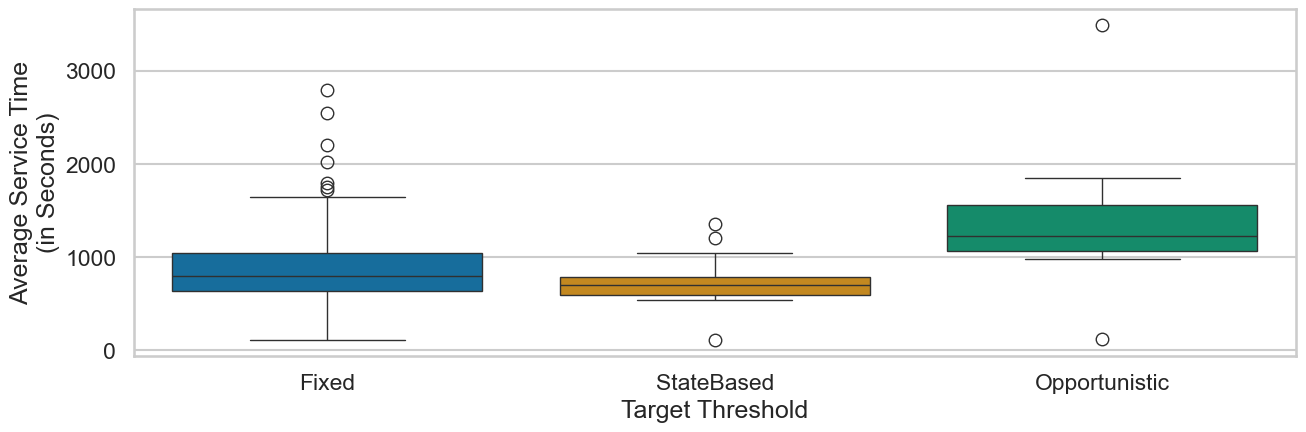

In [25]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_24580\886413577.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

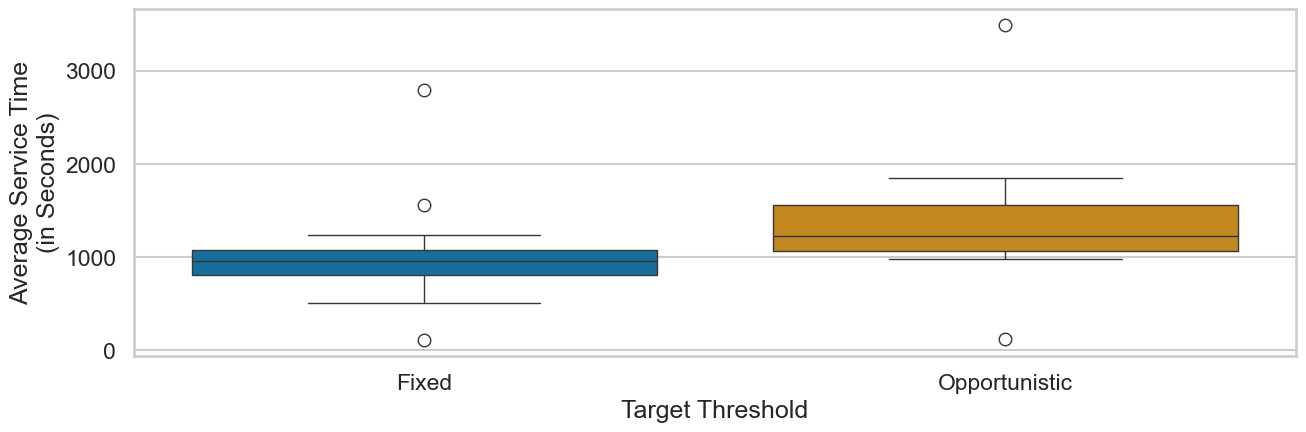

In [26]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False") & (df_paper["threshold"]=="th100")]
col_names = list(df_paper['GoChargingTH'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [27]:
df_paper

total_distance  total_shift_distance  distance_retrieval_ave  \
1         114048.2                   0.0                0.000000   
4         114048.2                   0.0                0.000000   
5         114048.2                   0.0                0.000000   
6         114048.2                   0.0                0.000000   
9         114048.2                   0.0                0.000000   
..             ...                   ...                     ...   
48       3457396.4              300053.6              178.731872   
51       3464713.2              300000.4              178.268269   
53       3498327.0              301263.2              178.932717   
54       3487081.6              294574.0              180.990142   
55       4337675.0              280417.2              200.098512   

    utilization_time   makespan    cycle_time   entropy  average_service_time  \
1           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
4           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
5           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
6           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
9           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
..               ...        ...           ...       ...                   ...   
48          0.016138  7658632.4  4.602876e+06  0.666654           2546.992910   
51          0.016158  7658177.8  4.707207e+06  0.659048           2790.589852   
53          0.016195  7658443.1  4.704734e+06  0.677594           2952.731043   
54          0.016131  7658547.5  4.671596e+06  0.690428           3490.330758   
55          0.016369  7658361.5  4.971194e+06  0.610335           9563.832846   

    max_average_service_time  throughput  ...  max_cs_queue  mean_cs_queue  \
1                 111.900000    0.005719  ...             1       0.001678   
4                 111.900000    0.005719  ...             1       0.001678   
5                 111.900000    0.005719  ...             1       0.001678   
6                 111.900000    0.005719  ...             1       0.001678   
9                 111.900000    0.005719  ...             1       0.001678   
..                       ...         ...  ...           ...            ...   
48               5802.512211    0.002459  ...            31       4.716296   
51               6607.419936    0.002459  ...            34       4.639622   
53               6607.419936    0.002459  ...            34       5.219337   
54               6607.419936    0.002459  ...            36       6.766580   
55               9819.998353    0.002459  ...            35       7.416003   

    mean_battery_level  index                       name    go_charging  \
1            92.289231      1           Fixed_th30_False          Fixed   
4            92.289231      6     FixedCharge_th40_False     StateBased   
5            92.289231      7           Fixed_th40_False          Fixed   
6            92.289231      9      FixedCharge_th40_True     StateBased   
9            92.289231     13           Fixed_th50_False          Fixed   
..                 ...    ...                        ...            ...   
48           51.909117     37           Fixed_th90_False          Fixed   
51           55.685263     43          Fixed_th100_False          Fixed   
53           63.020953     45            PPO_th100_False            PPO   
54           62.942978     44  Opportunistic_th100_False  Opportunistic   
55           45.406768     50               PPO_R1_False            PPO   

    interrupted  threshold  week   GoChargingTH  
1         False       th30     0      Fixedth30  
4         False       th40     0     StateBased  
5         False       th40     0      Fixedth40  
6          True       th40     0     StateBased  
9         False       th50     0      Fixedth50  
..          ...        ...   ...            ...  
48        False       th90

C:\Users\zm0714\AppData\Local\Temp\ipykernel_24580\3616588063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GoChargingTH'] = pd.Categorical(df['GoChargingTH'],
C:\Users\zm0714\AppData\Local\Temp\ipykernel_24580\3616588063.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels=col_names, rotation=90)


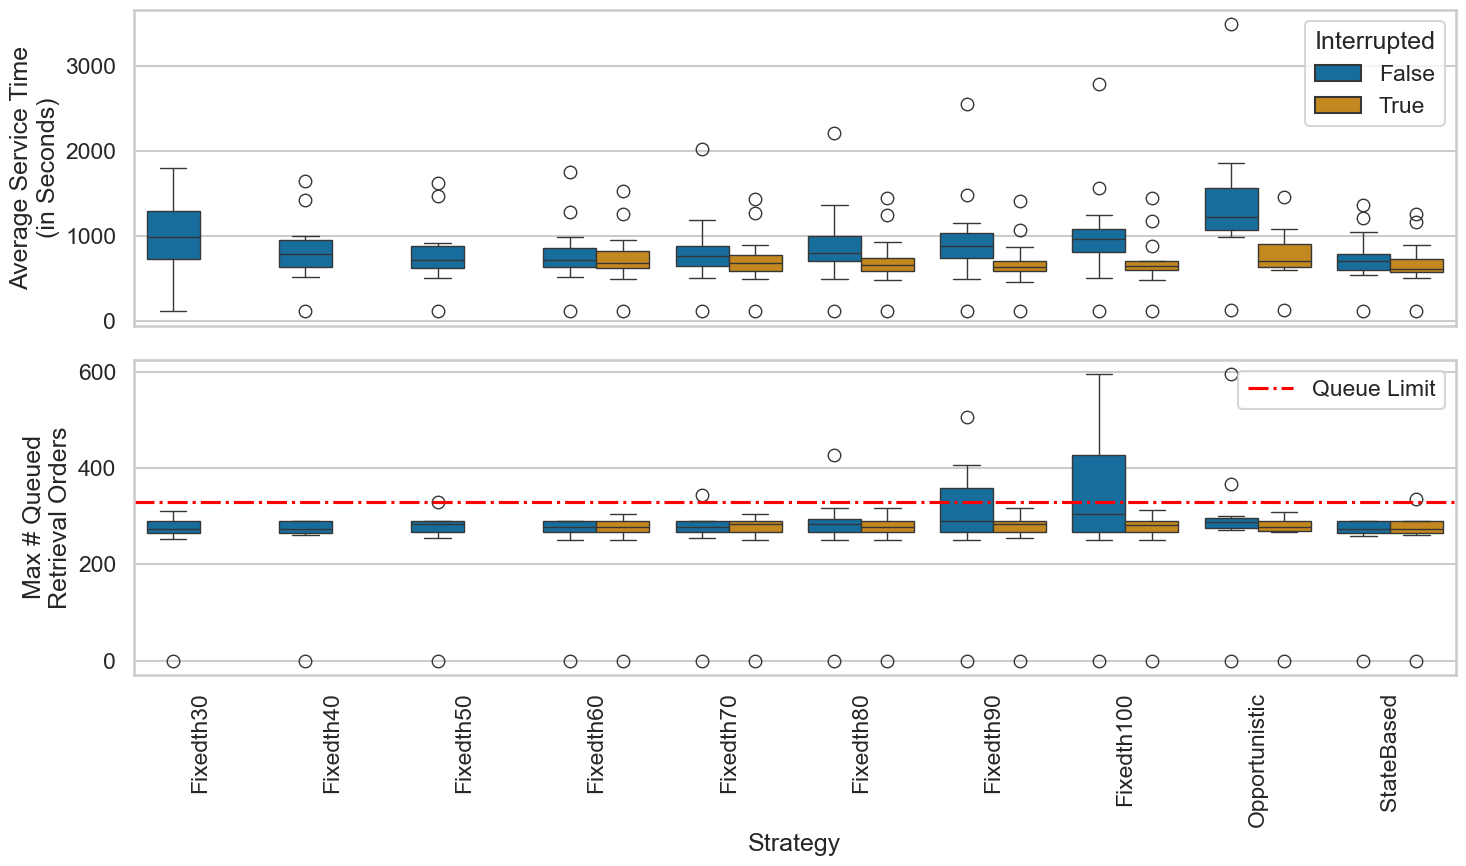

In [28]:
df = df_paper[(df_paper["go_charging"]!="PPO")] 
df['GoChargingTH'] = pd.Categorical(df['GoChargingTH'], 
                                  categories=["Fixedth30", "Fixedth40", "Fixedth50", "Fixedth60", "Fixedth70", "Fixedth80", "Fixedth90", "Fixedth100", "Opportunistic", "StateBased"],
                                  ordered=True)
col_names = ["Fixedth30", "Fixedth40", "Fixedth50", "Fixedth60", "Fixedth70", "Fixedth80", "Fixedth90", "Fixedth100", "Opportunistic", "StateBased"]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9), sharex=True)

# First plot
palette = cycle(pal)
sns.boxplot(x='GoChargingTH', y='average_service_time', data=df, palette=palette, hue="interrupted", ax=ax1)
ax1.set_xticklabels([])
ax1.set_xlabel("")
ax1.set_ylabel("Average Service Time\n(in Seconds)")
ax1.legend(title='Interrupted')

# Second plot
palette = cycle(pal)
sns.boxplot(x='GoChargingTH', y='max_retrieval_buffer', data=df, palette=palette, hue="interrupted", ax=ax2)
ax2.set_xticklabels(labels=col_names, rotation=90)
ax2.set_xlabel("Strategy")
line = ax2.axhline(330, color='red', linestyle='dashdot', label='Buffer Limit')
ax2.get_legend().remove()
ax2.legend(handles=[line], labels=['Queue Limit'])
ax2.set_ylabel("Max # Queued\nRetrieval Orders")

plt.tight_layout()
plt.savefig(f'{root_dir}/kpi_retrieval_orders_service_time_vs_weeks.png', dpi=200, bbox_inches='tight', pad_inches=0)

In [137]:
df_paper["GoChargingTH"].unique()

array(['Fixedth30', 'StateBased', 'Fixedth40', 'Fixedth50', 'Fixedth60',
       'Fixedth70', 'Fixedth80', 'Fixedth90', 'Fixedth100', 'PPOth100',
       'Opportunistic'], dtype=object)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\2341566000.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(rotation=90, labels=col_names)


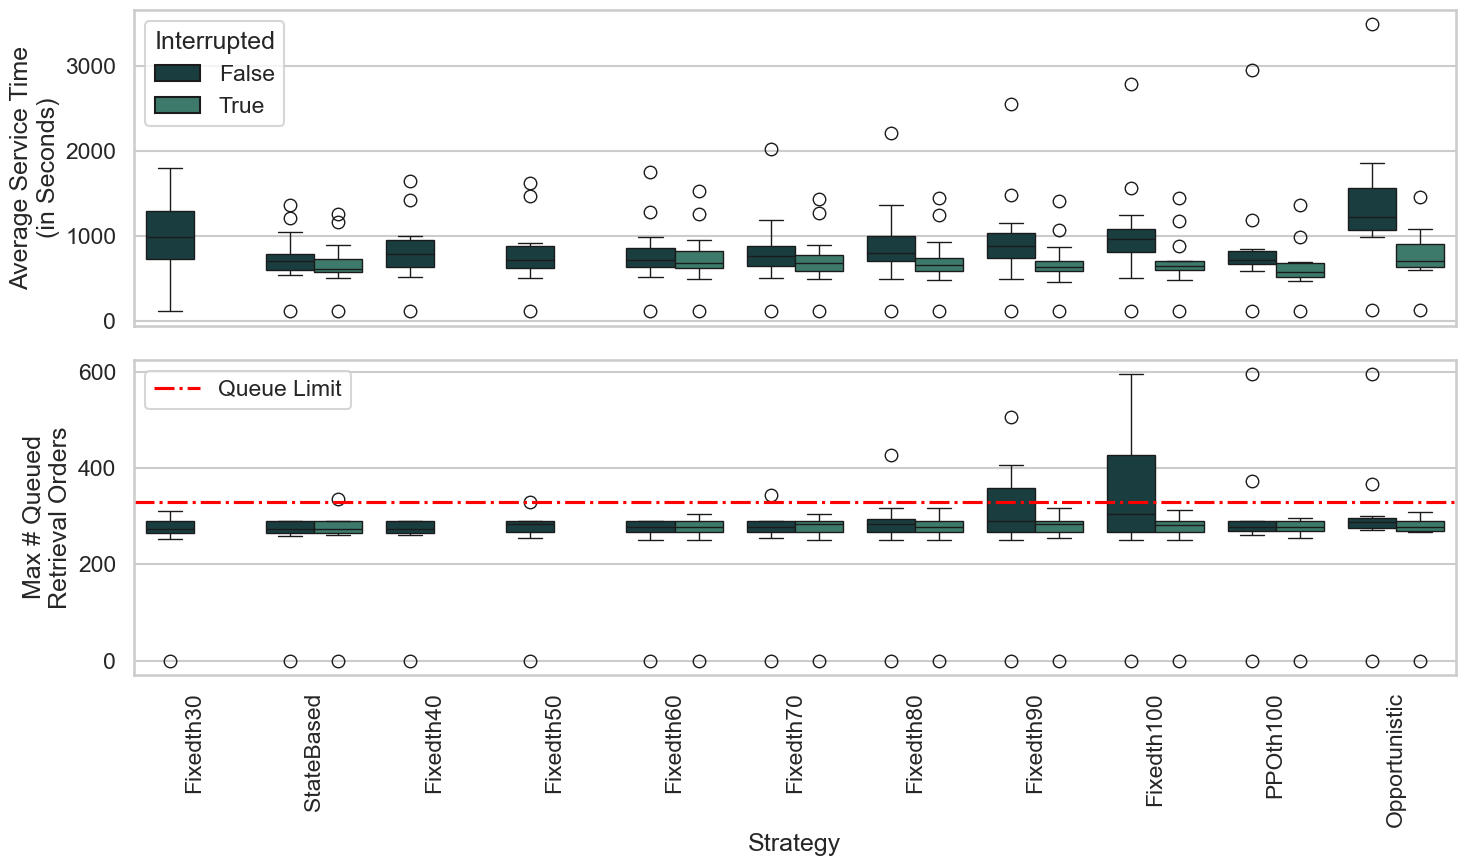

In [142]:
df = df_paper #[(df_paper["go_charging"]!="PPO")] 
# df['GoChargingTH'] = pd.Categorical(df['GoChargingTH'], 
#                                   categories=["Fixedth30", "Fixedth40", "Fixedth50", "Fixedth60", "Fixedth70", "Fixedth80", "Fixedth90", "Fixedth100", "Opportunistic", "StateBased"],
#                                   ordered=True)
col_names = df['GoChargingTH'].unique()
# col_names = ["Fixedth30", "Fixedth40", "Fixedth50", "Fixedth60", "Fixedth70", "Fixedth80", "Fixedth90", "Fixedth100", "Opportunistic", "StateBased"]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9), sharex=True)

# First plot
palette = cycle(pal)
sns.boxplot(x='GoChargingTH', y='average_service_time', data=df, palette=palette, hue="interrupted", ax=ax1)
ax1.set_xticklabels([])
ax1.set_xlabel("")
ax1.set_ylabel("Average Service Time\n(in Seconds)")
ax1.legend(title='Interrupted')

# Second plot
palette = cycle(pal)
sns.boxplot(x='GoChargingTH', y='max_retrieval_buffer', data=df, palette=palette, hue="interrupted", ax=ax2)
ax2.set_xticklabels(rotation=90, labels=col_names)
ax2.set_xlabel("Strategy")
line = ax2.axhline(330, color='red', linestyle='dashdot', label='Buffer Limit')
ax2.get_legend().remove()
ax2.legend(handles=[line], labels=['Queue Limit'])
ax2.set_ylabel("Max # Queued\nRetrieval Orders")

plt.tight_layout()
# plt.savefig(f'{root_dir}/kpi_retrieval_orders_service_time_vs_weeks.png', dpi=200, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Max # Retrieval Queue')

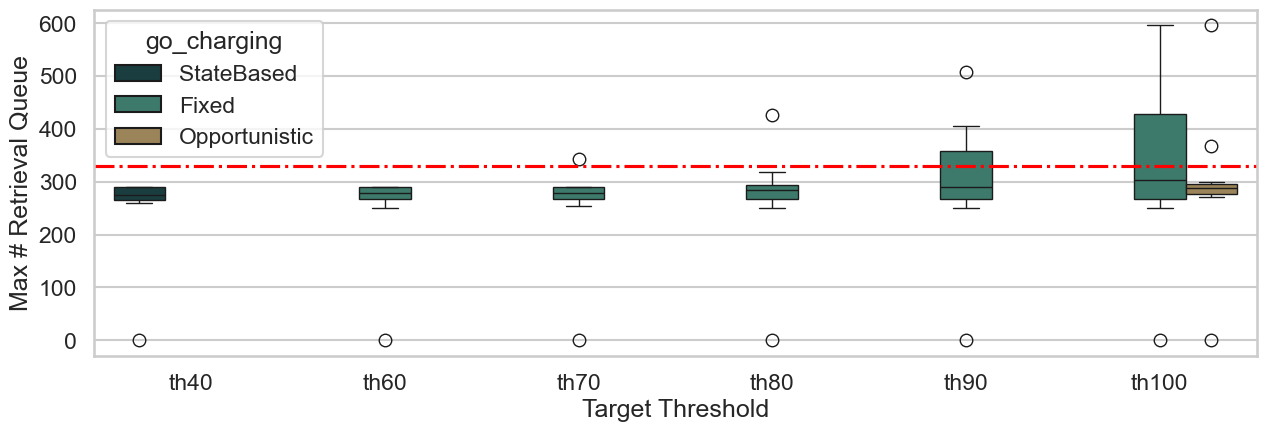

In [95]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='threshold', y='max_retrieval_buffer', data=df, palette=palette, hue="go_charging")
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Max # Retrieval Queue")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Average Service Time\n(in Seconds)')

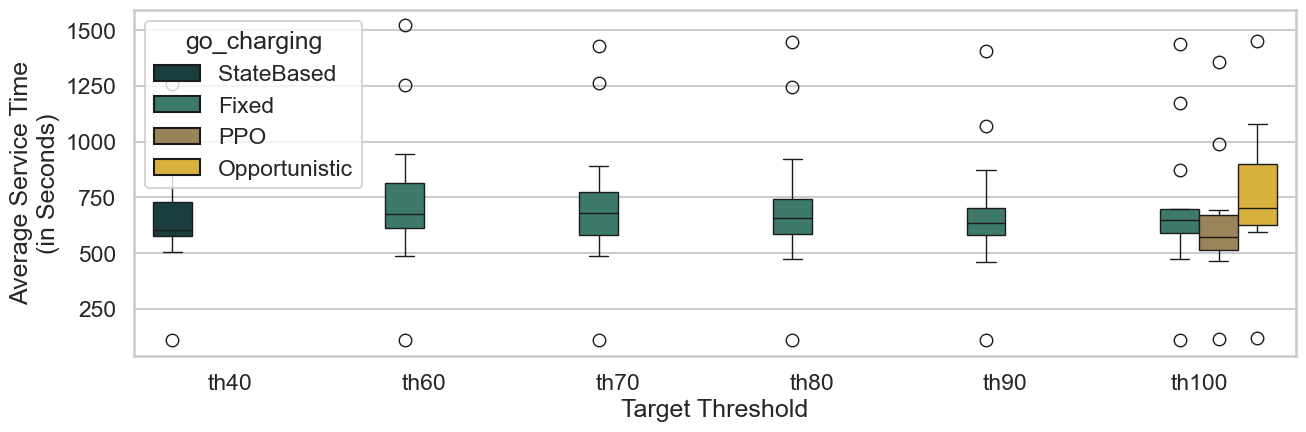

In [109]:
df = df_paper[(df_paper["interrupted"]=="True")] # (df_paper["go_charging"]!="PPO") &
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='threshold', y='average_service_time', data=df, palette=palette, hue="go_charging")
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(1600, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\836439954.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\836439954.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

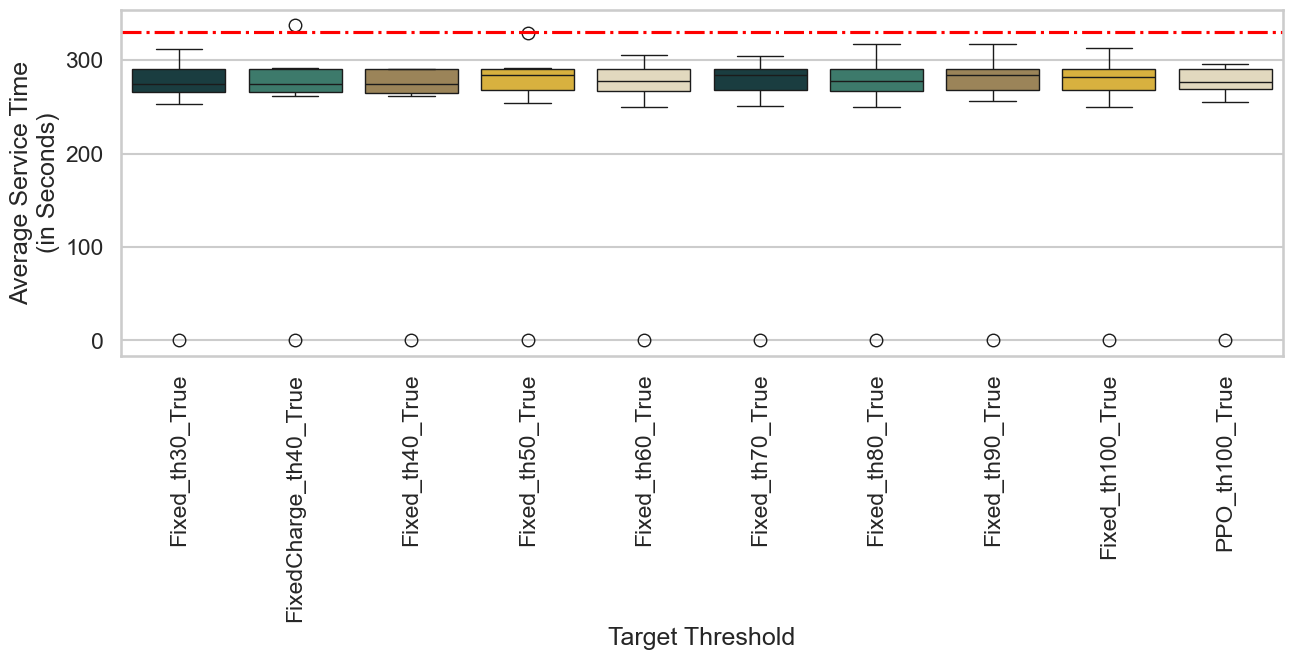

In [26]:
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\546834414.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='average_service_time', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\546834414.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

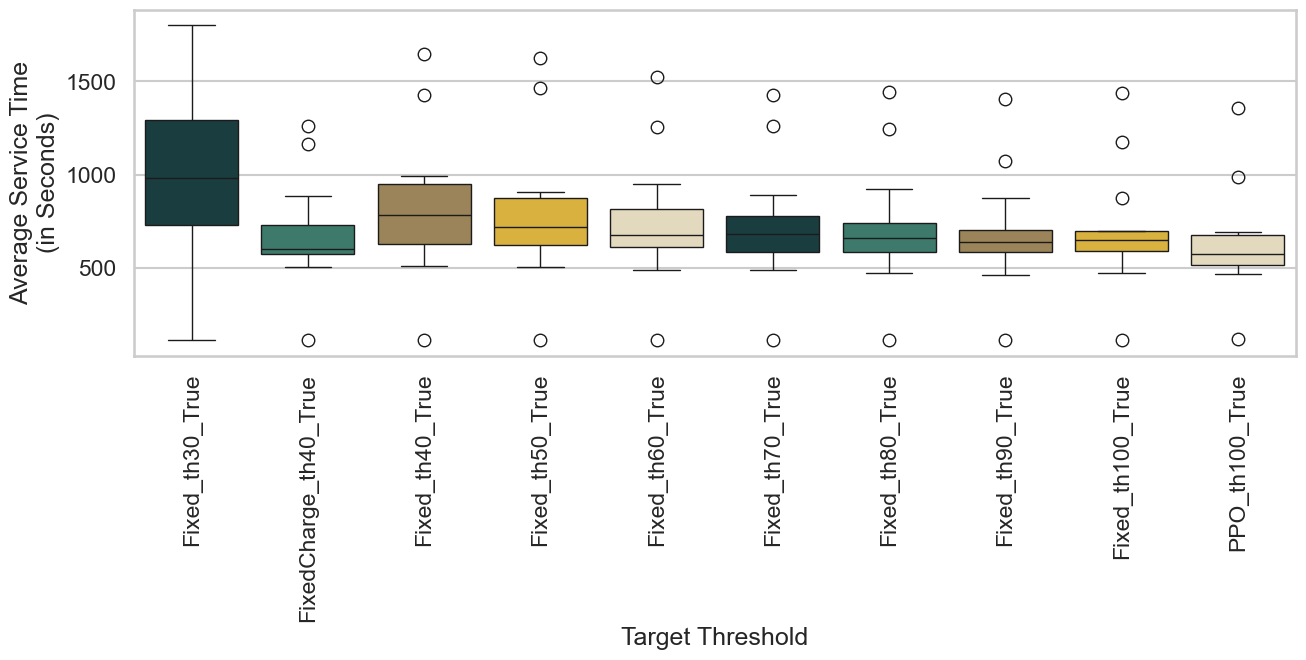

In [27]:
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='average_service_time', data=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")], palette=palette)
ax.set_xticklabels(labels=df_paper[(df_paper["interrupted"]=="True") & (df_paper["go_charging"] != "Opportunistic")].name.unique(), rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
# ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [28]:
df_paper

total_distance  total_shift_distance  distance_retrieval_ave  \
1         114048.2                   0.0                0.000000   
3         114048.2                   0.0                0.000000   
4         114048.2                   0.0                0.000000   
5         114048.2                   0.0                0.000000   
6         114048.2                   0.0                0.000000   
..             ...                   ...                     ...   
40       3437653.2              303402.4              176.895502   
43       3457396.4              300053.6              178.731872   
46       3464713.2              300000.4              178.268269   
48       3498327.0              301263.2              178.932717   
49       3487081.6              294574.0              180.990142   

    utilization_time   makespan    cycle_time   entropy  average_service_time  \
1           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
3           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
4           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
5           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
6           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
..               ...        ...           ...       ...                   ...   
40          0.016133  7658654.3  4.691678e+06  0.670837           2210.485305   
43          0.016138  7658632.4  4.602876e+06  0.666654           2546.992910   
46          0.016158  7658177.8  4.707207e+06  0.659048           2790.589852   
48          0.016195  7658443.1  4.704734e+06  0.677594           2952.731043   
49          0.016131  7658547.5  4.671596e+06  0.690428           3490.330758   

    max_average_service_time  throughput  ...  max_cs_queue  mean_cs_queue  \
1                 111.900000    0.005719  ...             1       0.001678   
3                 111.900000    0.005719  ...             1       0.001678   
4                 111.900000    0.005719  ...             1       0.001678   
5                 111.900000    0.005719  ...             1       0.001678   
6                 111.900000    0.005719  ...             1       0.001678   
..                       ...         ...  ...           ...            ...   
40               5038.679767    0.002459  ...            31       4.531992   
43               5802.512211    0.002459  ...            31       4.716296   
46               6607.419936    0.002459  ...            34       4.639622   
48               6607.419936    0.002459  ...            34       5.219337   
49               6607.419936    0.002459  ...            36       6.766580   

    mean_battery_level  index                       name    go_charging  \
1            92.289231      1           Fixed_th30_False          Fixed   
3            92.289231      4            Fixed_th30_True          Fixed   
4            92.289231      6     FixedCharge_th40_False     StateBased   
5            92.289231      7           Fixed_th40_False          Fixed   
6            92.289231      9      FixedCharge_th40_True     StateBased   
..                 ...    ...                        ...            ...   
40           48.419058     31           Fixed_th80_False          Fixed   
43           51.909117     37           Fixed_th90_False          Fixed   
46           55.685263     43          Fixed_th100_False          Fixed   
48           63.020953     45            PPO_th100_False            PPO   
49           62.942978     44  Opportunistic_th100_False  Opportunistic   

    interrupted  threshold  week   GoChargingTH  
1         False       th30     0      Fixedth30  
3          True       th30     0      Fixedth30  
4         False       th40     0     StateBased  
5         False       th40     0      Fixedth40  
6          True       th40     0     StateBased  
..          ...        ...   ...            ...  
40        False       th80

In [29]:
df_paper.groupby(by=["name"]).agg({"average_service_time": "mean", "max_average_service_time": "max", "mean_battery_level": "mean", "max_retrieval_buffer": "max"})

average_service_time  max_average_service_time  \
name                                                                        
FixedCharge_th40_False               741.247358               2517.792430   
FixedCharge_th40_True                679.235521               2517.792430   
Fixed_th100_False                   1029.584940               6607.419936   
Fixed_th100_True                     693.876762               2952.160785   
Fixed_th30_False                    1019.441479               2796.541291   
Fixed_th30_True                     1019.441479               2796.541291   
Fixed_th40_False                     824.891714               2517.792430   
Fixed_th40_True                      824.891714               2517.792430   
Fixed_th50_False                     779.252231               3039.071882   
Fixed_th50_True                      779.252231               3039.071882   
Fixed_th60_False                     787.297362               3574.032354   
Fixed_th60_True                      739.574698               3002.681399   
Fixed_th70_False                     830.032485               4463.925669   
Fixed_th70_True                      723.392698               3000.478553   
Fixed_th80_False                     885.050034               5038.679767   
Fixed_th80_True                      709.911485               3054.523651   
Fixed_th90_False                     953.186348               5802.512211   
Fixed_th90_True                      679.818180               3024.801434   
Opportunistic_th100_False           1372.180033               6607.419936   
Opportunistic_th100_True             755.777888               2952.160785   
PPO_th100_False                      868.388076               6607.419936   
PPO_th100_True                       626.828739               2952.160785   

                           mean_battery_level  max_retrieval_buffer  
name                                                                 
FixedCharge_th40_False              50.572020                   290  
FixedCharge_th40_True               44.379486                   337  
Fixed_th100_False                   59.433352                   596  
Fixed_th100_True                    49.372910                   313  
Fixed_th30_False                    32.360532                   312  
Fixed_th30_True                     32.360532                   312  
Fixed_th40_False                    36.229509                   290  
Fixed_th40_True                     36.229509                   290  
Fixed_th50_False                    40.142928                   329  
Fixed_th50_True                     40.142928                   329  
Fixed_th60_False                    43.917492                   290  
Fixed_th60_True                     41.926939                   305  
Fixed_th70_False                    47.815857                   344  
Fixed_th70_True                     43.896802                   304  
Fixed_th80_False                    51.704775                   427  
Fixed_th80_True                     45.869023                   317  
Fixed_th90_False                    55.592086                   507  
Fixed_th90_True                     47.753467                   317  
Opportunistic_th100_False           76.447299                   596  
Opportunistic_th100_True            61.251972                   308  
PPO_th100_False                     78.613337                   596  
PPO_th100_True                      61.825105                   296

In [30]:
df_paper.groupby(by=["go_charging", "interrupted", "threshold"]).agg({"average_service_time": "mean", "max_average_service_time": "max", "mean_battery_level": "mean", "max_retrieval_buffer": "max"})

average_service_time  \
go_charging   interrupted threshold                         
Fixed         False       th100               1029.584940   
                          th30                1019.441479   
                          th40                 824.891714   
                          th50                 779.252231   
                          th60                 787.297362   
                          th70                 830.032485   
                          th80                 885.050034   
                          th90                 953.186348   
              True        th100                693.876762   
                          th30                1019.441479   
                          th40                 824.891714   
                          th50                 779.252231   
                          th60                 739.574698   
                          th70                 723.392698   
                          th80                 709.911485   
                          th90                 679.818180   
Opportunistic False       th100               1372.180033   
              True        th100                755.777888   
PPO           False       th100                868.388076   
              True        th100                626.828739   
StateBased    False       th40                 741.247358   
              True        th40                 679.235521   

                                     max_average_service_time  \
go_charging   interrupted threshold                             
Fixed         False       th100                   6607.419936   
                          th30                    2796.541291   
                          th40                    2517.792430   
                          th50                    3039.071882   
                          th60                    3574.032354   
                          th70                    4463.925669   
                          th80                    5038.679767   
                          th90                    5802.512211   
              True        th100                   2952.160785   
                          th30                    2796.541291   
                          th40                    2517.792430   
                          th50                    3039.071882   
                          th60                    3002.681399   
                          th70                    3000.478553   
                          th80                    3054.523651   
                          th90                    3024.801434   
Opportunistic False       th100                   6607.419936   
              True        th100                   2952.160785   
PPO           False       th100                   6607.419936   
              True        th100                   2952.160785   
StateBased    False       th40                    2517.792430   
              True        th40                    2517.792430   

                                     mean_battery_level  max_retrieval_buffer  
go_charging   interrupted threshold                                            
Fixed         False       th100               59.433352                   596  
                          th30                32.360532                   312  
                          th40                36.229509                   290  
                          th50                40.142928                   329  
                          th60                43.917492                   290  
                          th70                47.815857                   344  
                          th80                51.704775                   427  
                          th90                55.592086                   507  
              True        th100               49.372910                   313  
                          th30                32.360532                   312  
                          th40                36.22

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\1926284539.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\1926284539.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

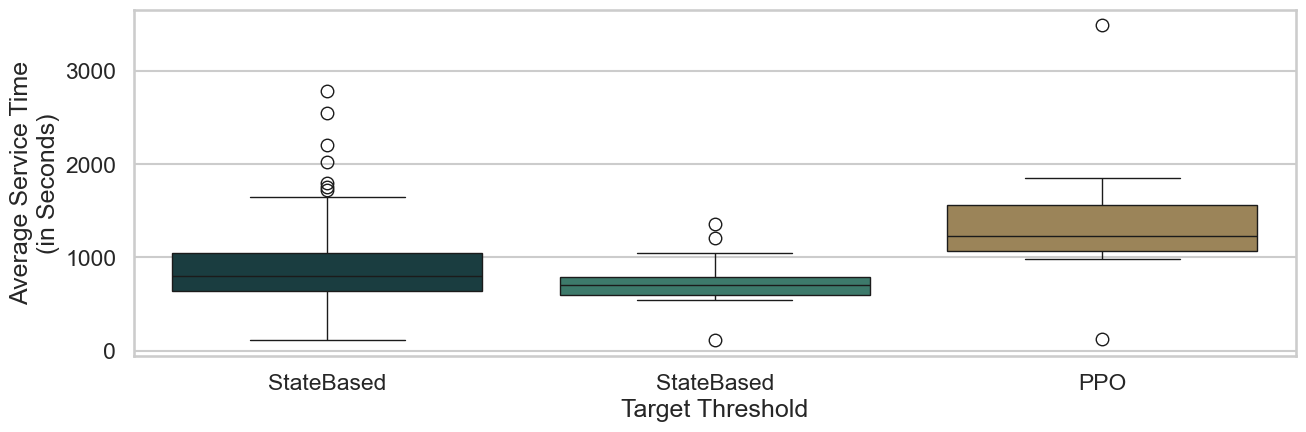

In [31]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['go_charging'].unique())
col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
ax.set_xticklabels(labels=col_names)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\3268636527.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\3268636527.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

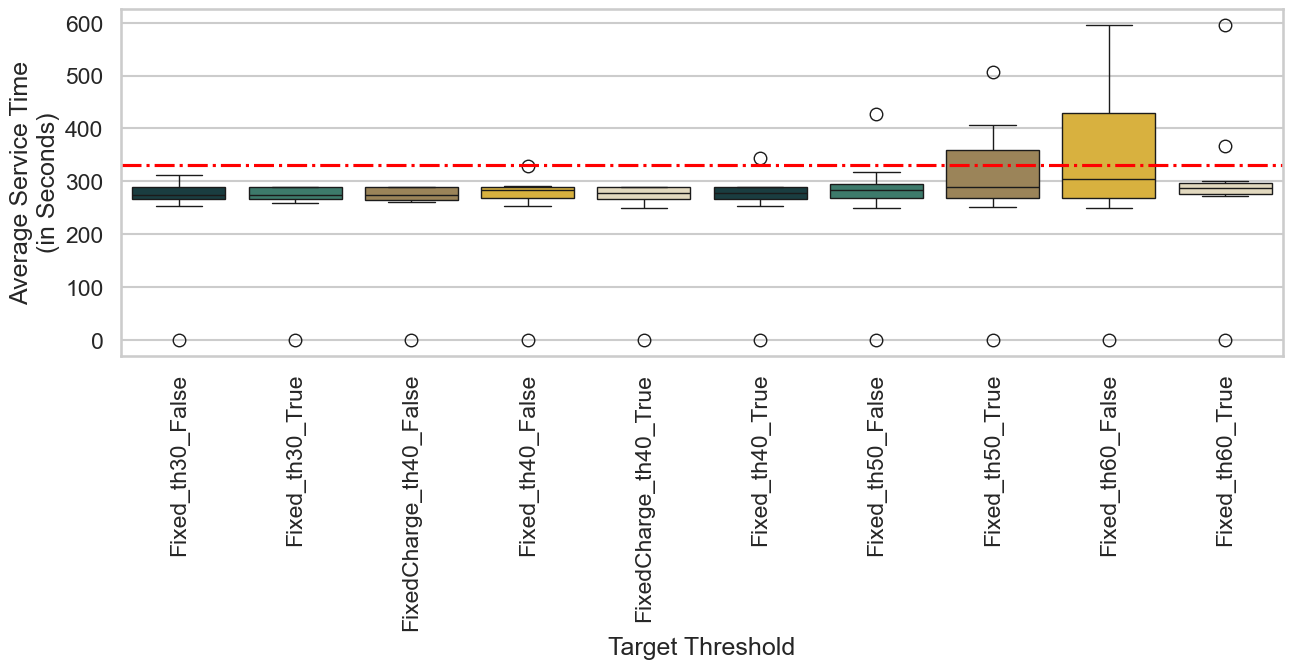

In [32]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='max_retrieval_buffer', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\2183095547.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='name', y='average_service_time', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\2183095547.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


Text(0, 0.5, 'Average Service Time\n(in Seconds)')

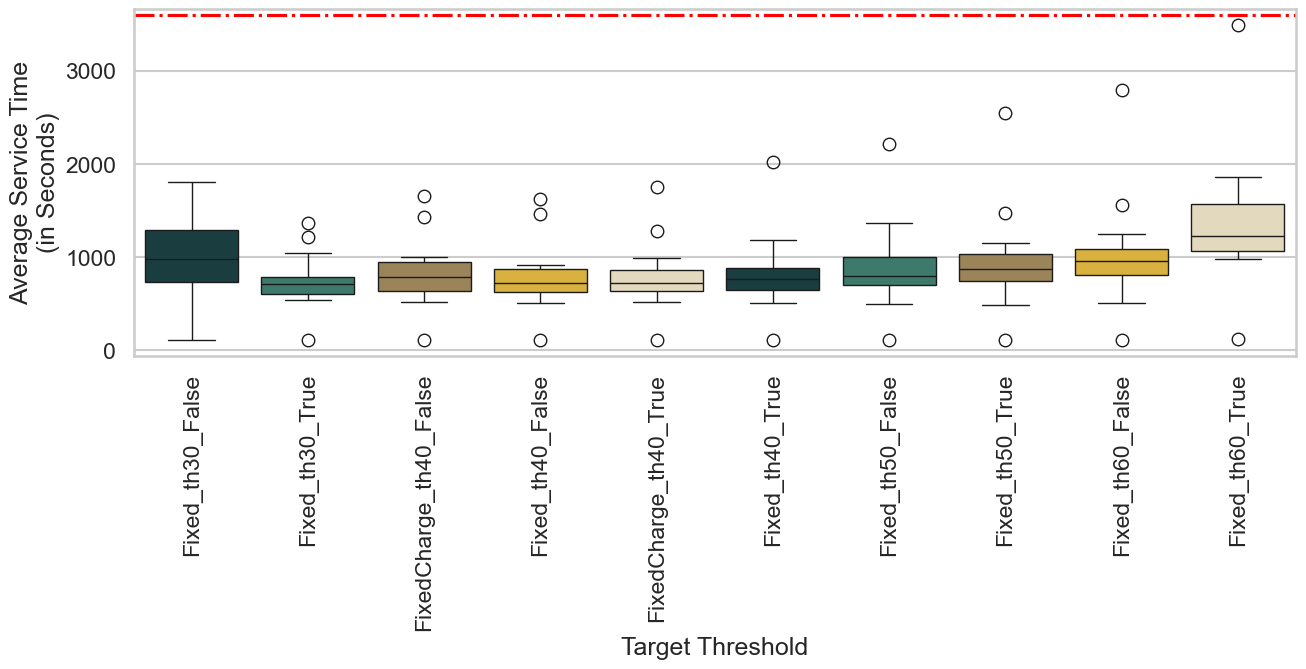

In [33]:
df = df_paper[(df_paper["go_charging"]!="PPO") & (df_paper["interrupted"]=="False")]
col_names = list(df_paper['name'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='name', y='average_service_time', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
ax.axhline(3600, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Average Service Time\n(in Seconds)')

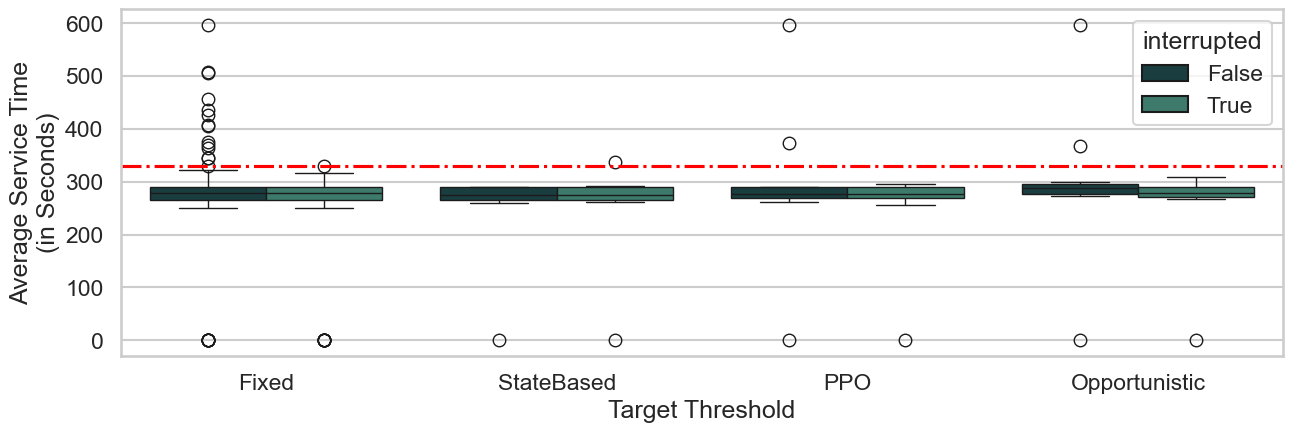

In [34]:
col_names = list(df_paper['name'].unique())
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='max_retrieval_buffer', data=df_paper, palette=palette, hue="interrupted")
# ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Target Threshold")
# ax2 = plt.twinx()
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
# plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_thresholds_vs_interrupt_per_week.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [35]:
df_paper

total_distance  total_shift_distance  distance_retrieval_ave  \
1         114048.2                   0.0                0.000000   
3         114048.2                   0.0                0.000000   
4         114048.2                   0.0                0.000000   
5         114048.2                   0.0                0.000000   
6         114048.2                   0.0                0.000000   
..             ...                   ...                     ...   
40       3437653.2              303402.4              176.895502   
43       3457396.4              300053.6              178.731872   
46       3464713.2              300000.4              178.268269   
48       3498327.0              301263.2              178.932717   
49       3487081.6              294574.0              180.990142   

    utilization_time   makespan    cycle_time   entropy  average_service_time  \
1           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
3           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
4           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
5           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
6           0.015718   104214.7  0.000000e+00  0.135804            109.936242   
..               ...        ...           ...       ...                   ...   
40          0.016133  7658654.3  4.691678e+06  0.670837           2210.485305   
43          0.016138  7658632.4  4.602876e+06  0.666654           2546.992910   
46          0.016158  7658177.8  4.707207e+06  0.659048           2790.589852   
48          0.016195  7658443.1  4.704734e+06  0.677594           2952.731043   
49          0.016131  7658547.5  4.671596e+06  0.690428           3490.330758   

    max_average_service_time  throughput  ...  max_cs_queue  mean_cs_queue  \
1                 111.900000    0.005719  ...             1       0.001678   
3                 111.900000    0.005719  ...             1       0.001678   
4                 111.900000    0.005719  ...             1       0.001678   
5                 111.900000    0.005719  ...             1       0.001678   
6                 111.900000    0.005719  ...             1       0.001678   
..                       ...         ...  ...           ...            ...   
40               5038.679767    0.002459  ...            31       4.531992   
43               5802.512211    0.002459  ...            31       4.716296   
46               6607.419936    0.002459  ...            34       4.639622   
48               6607.419936    0.002459  ...            34       5.219337   
49               6607.419936    0.002459  ...            36       6.766580   

    mean_battery_level  index                       name    go_charging  \
1            92.289231      1           Fixed_th30_False          Fixed   
3            92.289231      4            Fixed_th30_True          Fixed   
4            92.289231      6     FixedCharge_th40_False     StateBased   
5            92.289231      7           Fixed_th40_False          Fixed   
6            92.289231      9      FixedCharge_th40_True     StateBased   
..                 ...    ...                        ...            ...   
40           48.419058     31           Fixed_th80_False          Fixed   
43           51.909117     37           Fixed_th90_False          Fixed   
46           55.685263     43          Fixed_th100_False          Fixed   
48           63.020953     45            PPO_th100_False            PPO   
49           62.942978     44  Opportunistic_th100_False  Opportunistic   

    interrupted  threshold  week   GoChargingTH  
1         False       th30     0      Fixedth30  
3          True       th30     0      Fixedth30  
4         False       th40     0     StateBased  
5         False       th40     0      Fixedth40  
6          True       th40     0     StateBased  
..          ...        ...   ...            ...  
40        False       th80

# RL Results

In [29]:
rl_runs = {
    "R1": "hmdjfs33",
    "R2": "3x71b390",
    "R3": "umgysp3e",
    "R4": "qm61th79"
}

In [30]:
# run = api.run(f"{entity}/{project}/runs/{run_id}")

In [31]:
rl_rewards = pd.DataFrame()
for run_name in rl_runs:
    run = api.run(f"{entity}/{project}/runs/{rl_runs[run_name]}")
    key_reward = f"rollout/ep_rew_mean"
    reward_df = run.history(keys=[key_reward])
    interrupted = "False"
    if run_name == "R4":
        interrupted = "True"
    reward_df["Model"] = f"PPO_{run_name}_{interrupted}"
    reward_df.rename(columns={key_reward: "mean_ep_reward", "_step": "step"}, inplace=True)
    rl_rewards = pd.concat([rl_rewards, reward_df], ignore_index=True)

In [392]:
# rl_results = pd.DataFrame()
# df_rl_actions = pd.DataFrame()
# for run_name in rl_runs:
#     run = api.run(f"{entity}/{project}/runs/{rl_runs[run_name]}")
#     for i in range(n_partitions):
#         row = {
#             'total_distance': 0,
#             'total_shift_distance': 0,
#             'distance_retrieval_ave': 0,
#             'utilization_time': 0,
#             'makespan': 0,
#             'cycle_time': 0,
#             'entropy': 0,
#             'average_service_time': 0,
#             'max_average_service_time': 0,
#             'throughput': 0,
#             'max_delivery_buffer': 0,
#             'max_retrieval_buffer': 0,
#             'mean_retrieval_buffer': 0,
#             'max_agv_depleted': 0,
#             'mean_agv_depleted': 0,
#             'max_cs_queue': 0,
#             'mean_cs_queue': 0,
#             'mean_battery_level': 0,
#             'index': 0,
#             'name': 0,
#             'go_charging': 0,
#             'interrupted': 0,
#             'threshold': 0
#         }
#         key_service_time = f"logs/Evaluation/{i}/Servicetime"
#         key_retrieval_orders = f"logs/Evaluation/{i}/N_Retrieval_Orders"
#         key_battery = f"logs/Evaluation/{i}/Avg_Battery_Level"
#         key_action = f"logs/Evaluation/{i}/Action"
#         
#         st_df = run.history(keys=[key_service_time])
#         st_df["Model"] = run_name
#         st_df["week"] = i
#         st_df.drop("_step", axis=1, inplace=True)
#         st_df.rename(columns={key_service_time: "average_service_time"}, inplace=True)
#         
#         ret_df = run.history(keys=[key_retrieval_orders])
#         ret_df["reward_setting"] = run_name
#         ret_df["week"] = i
#         ret_df.drop("_step", axis=1, inplace=True)
#         ret_df.rename(columns={key_retrieval_orders: "queued_retrieval_orders"}, inplace=True)
#         
#         battery_df = run.history(keys=[key_battery])
#         battery_df["reward_setting"] = f"PPO{run_name}"
#         battery_df["week"] = i
#         battery_df.drop("_step", axis=1, inplace=True)
#         battery_df.rename(columns={key_battery: "mean_battery_level"}, inplace=True)
#         
#         action_df = run.history(keys=[key_action])
#         action_df["reward_setting"] = run_name
#         action_df["week"] = i
#         action_df.drop("_step", axis=1, inplace=True)
#         action_df.rename(columns={key_action: "action"}, inplace=True)
#         
#         df_rl_actions = pd.concat([df_rl_actions, action_df], ignore_index=True)
#         row["average_service_time"] = st_df["average_service_time"].iloc[-1]
#         row["max_average_service_time"] = st_df["average_service_time"].max()
#         row["max_retrieval_buffer"] = ret_df["queued_retrieval_orders"].max()
#         row["mean_retrieval_buffer"] = ret_df["queued_retrieval_orders"].mean()
#         row["mean_battery_level"] = battery_df["mean_battery_level"].mean()
#         row["index"] = i
#         row["go_charging"] = f"PPO_{run_name}"
#         row["interrupted"] = "False"
#         row["threshold"] = "All"
#         df_row = pd.DataFrame([row])  
#         rl_results = pd.concat([rl_results, df_row], ignore_index=True)
#     

In [396]:
rl_rewards 

step  mean_ep_reward reward_setting  scaled_reward
0       47531.0    -36260.07400             R1       0.000000
1       53888.0    -36260.07400             R1       0.000000
2       63987.0    -36260.07400             R1       0.000000
3       67956.0    -36260.07400             R1       0.000000
4       72293.0    -36260.07400             R1       0.000000
...         ...             ...            ...            ...
1995  3991128.0      -690.78064             R4       0.953968
1996  3996929.0      -690.78064             R4       0.953968
1997  4004960.0      -690.78064             R4       0.953968
1998  4007144.0      -690.10780             R4       0.954015
1999  4023313.0      -690.10780             R4       0.954015

[2000 rows x 4 columns]

C:\Users\zm0714\AppData\Local\Temp\ipykernel_24580\2230903371.py:15: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(


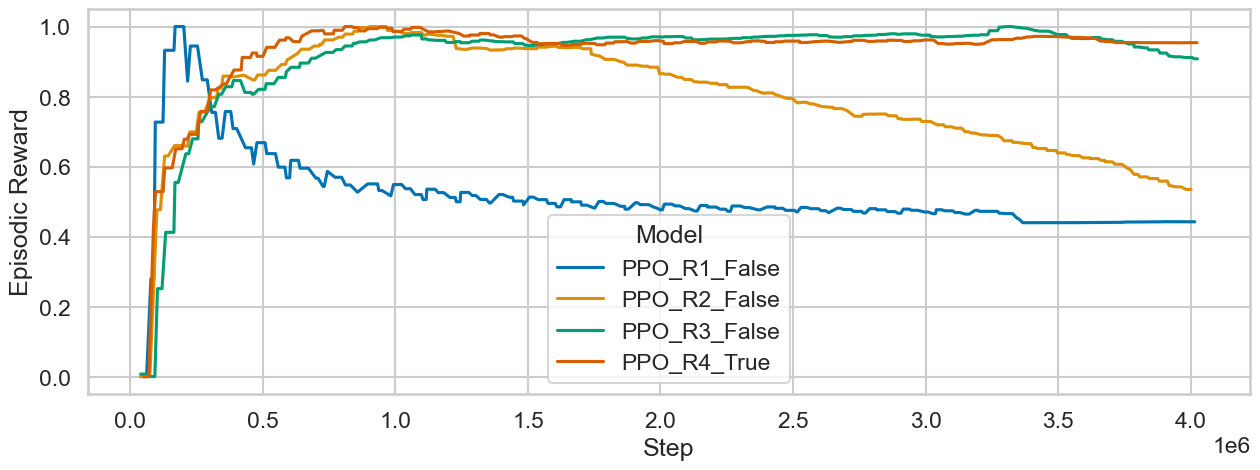

In [32]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the mean_ep_reward column for each reward setting
rl_rewards['scaled_reward'] = rl_rewards.groupby('Model')['mean_ep_reward'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Plot scaled rewards
_, ax = plt.subplots(figsize=(15, 5))
ax.ticklabel_format(axis='x', style='sci')
ax = sns.lineplot(
    ax=ax,
    x="step",
    y="scaled_reward",
    data=rl_rewards,
    palette=pal,
    hue="Model"
)
ax.set_xlabel("Step")
ax.set_ylabel("Episodic Reward")
plt.savefig(f'{root_dir}/ppo_scaled_rewards.png', dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\1518020170.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\1518020170.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


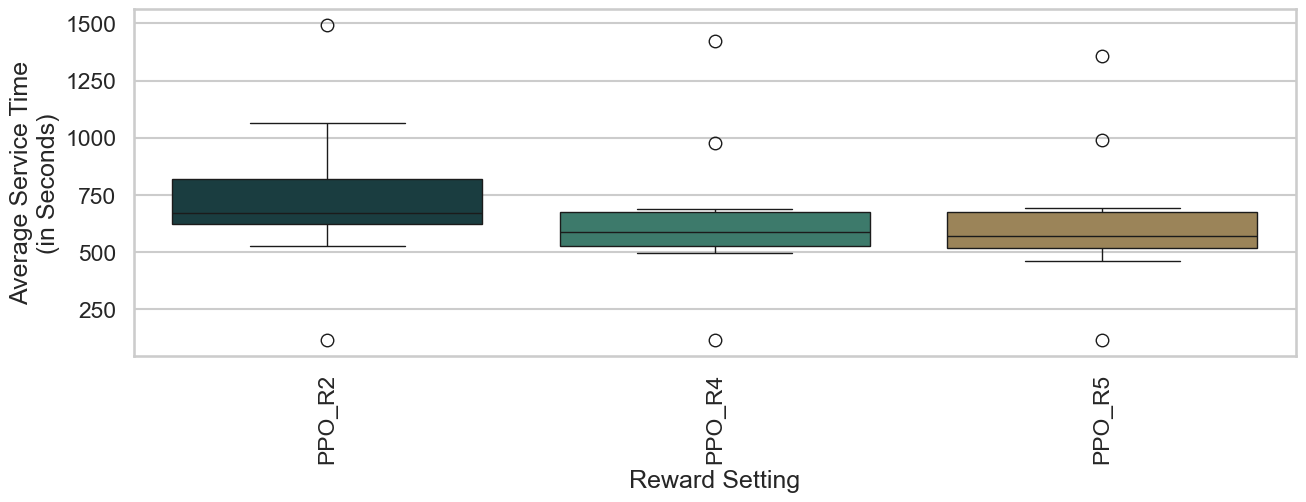

In [43]:
df = rl_results[rl_results["go_charging"] != "PPO_R1"]
col_names = list(df['go_charging'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='average_service_time', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Reward Setting")
# ax.axhline(3600, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Average Service Time\n(in Seconds)")
plt.savefig(f'{root_dir}/boxplot__kpi__average_service_time_ppo_rewards.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)

C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\2859838622.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='go_charging', y='max_retrieval_buffer', data=df, palette=palette)
C:\Users\zm0714\AppData\Local\Temp\ipykernel_35396\2859838622.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=col_names, rotation=90)


Text(0, 0.5, 'Max # Retrieval Queue')

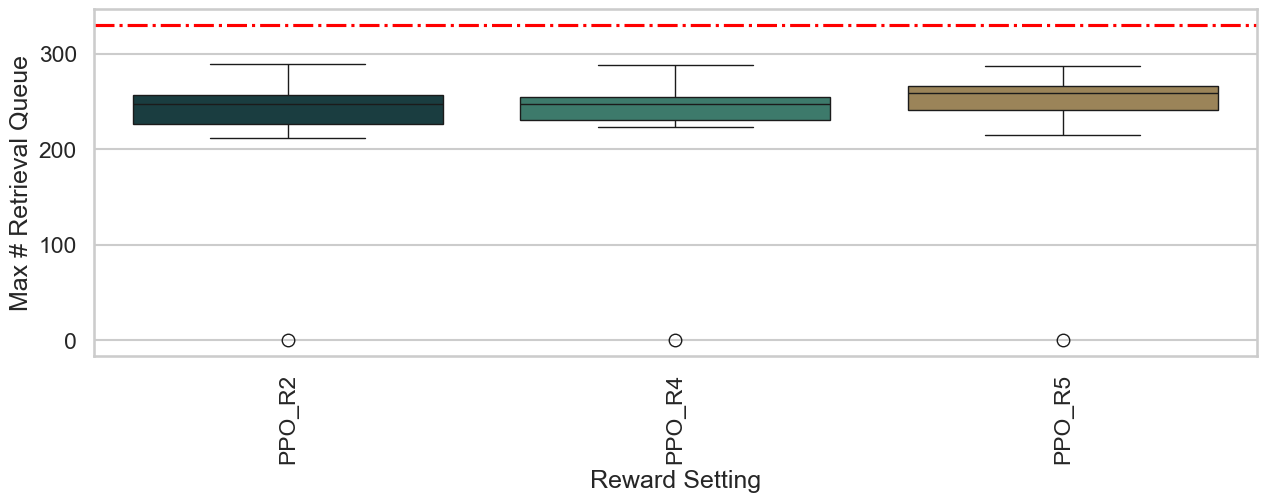

In [44]:
df = rl_results[rl_results["go_charging"] != "PPO_R1"]
col_names = list(df['go_charging'].unique())
# col_names[0] = "StateBased"
# col_names = [name.strip("Avg. Service Time") for name in col_names]
# col_names = [int(col_name) for col_name in col_names]
# col_names.sort()
# col_names = [th for th in col_names] # .split("th")[1]
_, ax = plt.subplots(figsize=(15, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle(pal)
ax = sns.boxplot(x='go_charging', y='max_retrieval_buffer', data=df, palette=palette)
ax.set_xticklabels(labels=col_names, rotation=90)
ax.set_xlabel("Reward Setting")
ax.axhline(330, color='red', linestyle='dashdot', label='Limit')

# ax2 = plt.twinx()
# sns.lineplot(data=df_fill_lvl.reset_index(), x='partition', y="fill_level", color="red", ax=ax2)
# ax2.set_ylabel("Fill Level")
ax.set_ylabel("Max # Retrieval Queue")
# plt.savefig(f'{root_dir}/boxplot__kpi__queued_retrieval_orders_ppo_rewards.png', 
#                 dpi=200, bbox_inches='tight', pad_inches=0)

In [45]:
df_rl_actions

action reward_setting  week
0           8             R1     0
1           8             R1     0
2           8             R1     0
3           8             R1     0
4           8             R1     0
...       ...            ...   ...
27995       0             R5    13
27996       0             R5    13
27997       0             R5    13
27998       0             R5    13
27999       0             R5    13

[28000 rows x 3 columns]

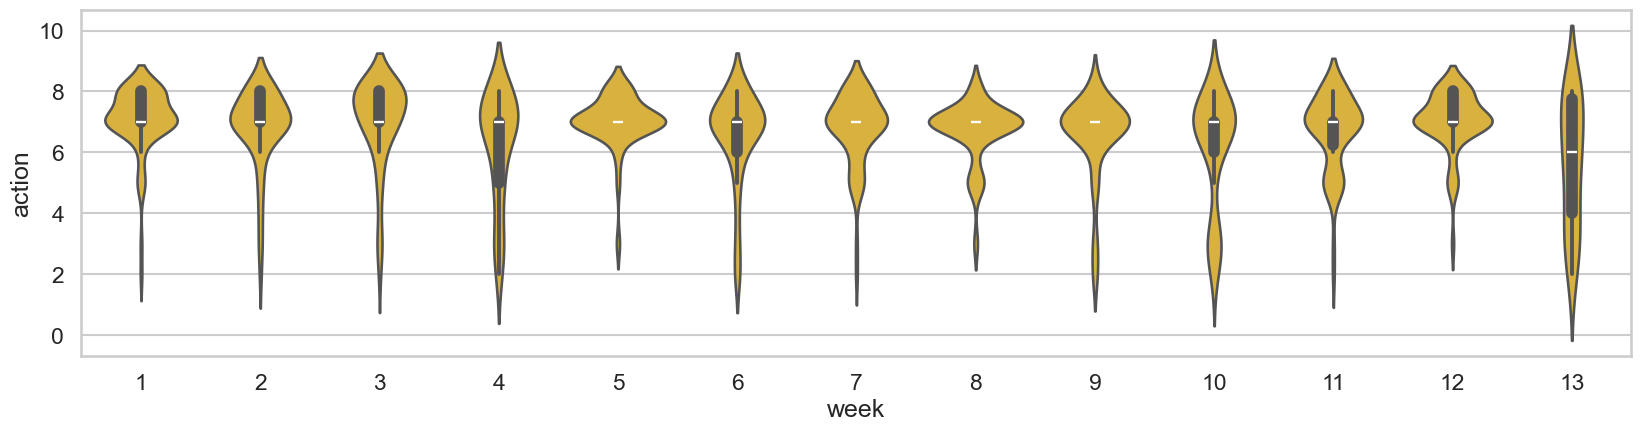

In [46]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal[0], pal[3]])
ax = sns.violinplot(ax=ax, x="week", y="action", data=df_rl_actions[(df_rl_actions["reward_setting"]=="R4") & (df_rl_actions["action"]!=0) & (df_rl_actions["week"]!=0)], color=pal[3])

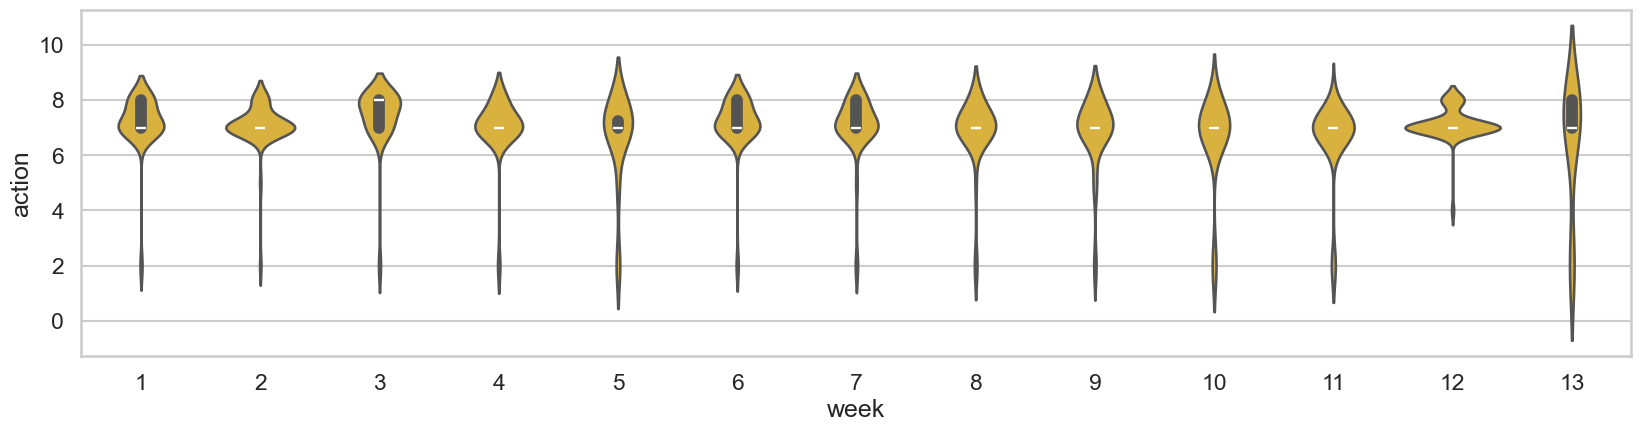

In [47]:
_, ax = plt.subplots(figsize=(20, 4.5))
ax.ticklabel_format(axis='x', style='sci')
palette = cycle([pal[0], pal[3]])
ax = sns.violinplot(ax=ax, x="week", y="action", data=df_rl_actions[(df_rl_actions["reward_setting"]=="R2") & (df_rl_actions["action"]!=0) & (df_rl_actions["week"]!=0)], color=pal[3])

In [196]:
rl_results_grouped = rl_results.groupby(by="go_charging").agg({"average_service_time": "mean", "max_average_service_time": "max", "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean"})

In [351]:
df_paper.columns

Index(['total_distance', 'total_shift_distance', 'distance_retrieval_ave',
       'utilization_time', 'makespan', 'cycle_time', 'entropy',
       'average_service_time', 'max_average_service_time', 'throughput',
       'max_delivery_buffer', 'max_retrieval_buffer', 'mean_retrieval_buffer',
       'max_agv_depleted', 'mean_agv_depleted', 'max_cs_queue',
       'mean_cs_queue', 'mean_battery_level', 'index', 'name', 'go_charging',
       'interrupted', 'threshold', 'week', 'GoChargingTH'],
      dtype='object')

In [21]:
df_paper.groupby(by=["name", "interrupted"]).agg({"average_service_time": "mean", 
                                                         "max_average_service_time": "max",
                                                         "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean", "total_distance": "mean"}).reset_index()

name interrupted  average_service_time  \
0      FixedCharge_th40_False       False            741.247358   
1       FixedCharge_th40_True        True            679.235521   
2           Fixed_th100_False       False           1029.584940   
3            Fixed_th100_True        True            693.876762   
4            Fixed_th30_False       False           1019.441479   
5            Fixed_th40_False       False            824.891714   
6            Fixed_th50_False       False            779.252231   
7            Fixed_th60_False       False            787.297362   
8             Fixed_th60_True        True            739.574698   
9            Fixed_th70_False       False            830.032485   
10            Fixed_th70_True        True            723.392698   
11           Fixed_th80_False       False            885.050034   
12            Fixed_th80_True        True            709.911485   
13           Fixed_th90_False       False            953.186348   
14            Fixed_th90_True        True            679.818180   
15  Opportunistic_th100_False       False           1372.180033   
16   Opportunistic_th100_True        True            755.777888   
17               PPO_R1_False       False           5384.164658   
18               PPO_R2_False       False            730.751225   
19                PPO_R2_True        True            637.915538   
20               PPO_R3_False       False            640.621108   
21                PPO_R3_True        True            628.276861   
22                PPO_R4_True        True            626.828739   
23            PPO_th100_False       False            868.388076   
24             PPO_th100_True        True            626.828739   

    max_average_service_time  max_retrieval_buffer  mean_retrieval_buffer  \
0                2517.792430                   290              23.840742   
1                2517.792430                   337              21.986172   
2                6607.419936                   596              30.221158   
3                2952.160785                   313              22.531734   
4                2796.541291                   312              30.150117   
5                2517.792430                   290              25.250937   
6                3039.071882                   329              24.550626   
7                3574.032354                   290              24.530914   
8                3002.681399                   305              23.810322   
9                4463.925669                   344              25.154811   
10               3000.478553                   304              23.242387   
11               5038.679767                   427              26.679448   
12               3054.523651                   317              23.030884   
13               5802.512211                   507              28.253037   
14               3024.801434                   317              22.451649   
15               6607.419936                   596              42.041669   
16               2952.160785                   308              25.315230   
17               9819.998353                   975             171.672010   
18               2880.398203                   298              23.682772   
19               2509.080564                   291              21.049691   
20               3096.694818                   290              21.626652   
21               2869.374182                   290              20.745709   
22               2952.160785                   296              21.019379   
23               6607.419936                   596              27.850864   
24               2952.160785                   296              21.019379   

    mean_battery_level  total_distance  
0            50.572020    5.442462e+06  
1            44.379486    5.479858e+06  
2            59.433352    5.394308e+06  
3            49.372910    5.432305e+06  
4            32.360532    5.694409e+06  
5            36.229509    5.51528

In [22]:
df_heuristics_grouped = df_paper.groupby(by=["name", "interrupted"]).agg({"average_service_time": "mean", 
                                                         "max_average_service_time": "max",
                                                         "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean", "total_distance": "mean"}).reset_index()
df_heuristics_grouped = df_heuristics_grouped[df_heuristics_grouped["name"] != "PPO_th100_True"]
df_heuristics_3best = df_heuristics_grouped.sort_values(by=["average_service_time", "max_retrieval_buffer"]).head(3)
df_heuristics_3worst = df_heuristics_grouped.sort_values(by=["average_service_time", "max_retrieval_buffer"], ascending=False).head(3)

In [23]:
df_heuristics_grouped

name interrupted  average_service_time  \
0      FixedCharge_th40_False       False            741.247358   
1       FixedCharge_th40_True        True            679.235521   
2           Fixed_th100_False       False           1029.584940   
3            Fixed_th100_True        True            693.876762   
4            Fixed_th30_False       False           1019.441479   
5            Fixed_th40_False       False            824.891714   
6            Fixed_th50_False       False            779.252231   
7            Fixed_th60_False       False            787.297362   
8             Fixed_th60_True        True            739.574698   
9            Fixed_th70_False       False            830.032485   
10            Fixed_th70_True        True            723.392698   
11           Fixed_th80_False       False            885.050034   
12            Fixed_th80_True        True            709.911485   
13           Fixed_th90_False       False            953.186348   
14            Fixed_th90_True        True            679.818180   
15  Opportunistic_th100_False       False           1372.180033   
16   Opportunistic_th100_True        True            755.777888   
17               PPO_R1_False       False           5384.164658   
18               PPO_R2_False       False            730.751225   
19                PPO_R2_True        True            637.915538   
20               PPO_R3_False       False            640.621108   
21                PPO_R3_True        True            628.276861   
22                PPO_R4_True        True            626.828739   
23            PPO_th100_False       False            868.388076   

    max_average_service_time  max_retrieval_buffer  mean_retrieval_buffer  \
0                2517.792430                   290              23.840742   
1                2517.792430                   337              21.986172   
2                6607.419936                   596              30.221158   
3                2952.160785                   313              22.531734   
4                2796.541291                   312              30.150117   
5                2517.792430                   290              25.250937   
6                3039.071882                   329              24.550626   
7                3574.032354                   290              24.530914   
8                3002.681399                   305              23.810322   
9                4463.925669                   344              25.154811   
10               3000.478553                   304              23.242387   
11               5038.679767                   427              26.679448   
12               3054.523651                   317              23.030884   
13               5802.512211                   507              28.253037   
14               3024.801434                   317              22.451649   
15               6607.419936                   596              42.041669   
16               2952.160785                   308              25.315230   
17               9819.998353                   975             171.672010   
18               2880.398203                   298              23.682772   
19               2509.080564                   291              21.049691   
20               3096.694818                   290              21.626652   
21               2869.374182                   290              20.745709   
22               2952.160785                   296              21.019379   
23               6607.419936                   596              27.850864   

    mean_battery_level  total_distance  
0            50.572020    5.442462e+06  
1            44.379486    5.479858e+06  
2            59.433352    5.394308e+06  
3            49.372910    5.432305e+06  
4            32.360532    5.694409e+06  
5            36.229509    5.515282e+06  
6            40.142928    5.458562e+06  
7            43.917492    5.436482e+06  
8            41.926939    5.452929e+06  
9            

In [24]:
def create_latex_table(df):
    # Find the minimum values for each column that needs highlighting
    min_avg_service_time = df['average_service_time'].min()
    min_max_retrieval_buffer = df['max_retrieval_buffer'].min()
    min_mean_retrieval_buffer = df['mean_retrieval_buffer'].min()
    min_mean_battery_level = df['mean_battery_level'].min()
    min_mean_travel_distance = ((df['total_distance'] / 1000) / 40).min()
    
    latex_table = """\\begin{table}[!h]
\\setlength{\\tabcolsep}{2pt}
\\renewcommand{\\arraystretch}{1.2}
\\scriptsize
\\begin{tabularx}{\\textwidth}{
>{\\raggedright\\arraybackslash}p{2cm}CCCCCC}
\\toprule
\\multirow{2}{*}{\\textbf{Strategy}} & \\textbf{Avg Service Time (s)} & \\textbf{Max Retrieval Queue} & \\textbf{Mean Retrieval Queue} & \\textbf{Mean Battery Level} & \\textbf{Mean Travel Distance (km/AMR)} \\\\[6pt]
\\midrule
"""
    
    # Group rows by the 'interrupted' column
    for interrupted, group in df.groupby("interrupted"):
        # Add a grouping header
        header = "Interrupted Charging" if interrupted else "Non-Interrupted Charging"
        latex_table += f"\\multicolumn{{6}}{{l}}{{\\textbf{{{header}}}}} \\\\\\midrule\n"
        
        # Add rows for each group
        for _, row in group.iterrows():
            # Determine if the current value is the minimum for each column
            avg_service_time = (
                f"\\textbf{{{row['average_service_time']:.2f}}}"
                if row['average_service_time'] == min_avg_service_time
                else f"{row['average_service_time']:.2f}"
            )
            max_retrieval_buffer = (
                f"\\textbf{{{row['max_retrieval_buffer']}}}"
                if row['max_retrieval_buffer'] == min_max_retrieval_buffer
                else f"{row['max_retrieval_buffer']}"
            )
            mean_retrieval_buffer = (
                f"\\textbf{{{row['mean_retrieval_buffer']:.2f}}}"
                if row['mean_retrieval_buffer'] == min_mean_retrieval_buffer
                else f"{row['mean_retrieval_buffer']:.2f}"
            )
            mean_battery_level = (
                f"\\textbf{{{row['mean_battery_level']:.2f}}}"
                if row['mean_battery_level'] == min_mean_battery_level
                else f"{row['mean_battery_level']:.2f}"
            )
            mean_travel_distance = (
                f"\\textbf{{{(row['total_distance'] / 1000) / 40:.2f}}}"
                if ((row['total_distance'] / 1000) / 40) == min_mean_travel_distance
                else f"{(row['total_distance'] / 1000) / 40:.2f}"
            )
            
            # Format the strategy name
            name = row['name'].replace("FixedCharge", "StateBased").replace("Opportunistic", "OPP").replace("Fixed", "").replace("_", "")
            
            # Add the row to the table
            latex_table += (
                f"\\textbf{{{name}}} & \\makecell[c]{{{avg_service_time}}} & "
                f"\\makecell[c]{{{max_retrieval_buffer}}} & \\makecell[c]{{{mean_retrieval_buffer}}} & "
                f"\\makecell[c]{{{mean_battery_level}}} & \\makecell[c]{{{mean_travel_distance}}} \\\\\n"
            )
    
    latex_table += """\\bottomrule
\\end{tabularx}
\\caption{\\small Comparison of Charging Strategies. Interrupted indicates interruption of charging at 50\\%.}
\\label{tab:charging_results}
\\end{table}"""
    
    return latex_table

# Example usage
latex_table = create_latex_table(df_heuristics_grouped.sort_values(by=["average_service_time", "max_retrieval_buffer"]))
print(latex_table)

\begin{table}[!h]
\setlength{\tabcolsep}{2pt}
\renewcommand{\arraystretch}{1.2}
\scriptsize
\begin{tabularx}{\textwidth}{
>{\raggedright\arraybackslash}p{2cm}CCCCCC}
\toprule
\multirow{2}{*}{\textbf{Strategy}} & \textbf{Avg Service Time (s)} & \textbf{Max Retrieval Queue} & \textbf{Mean Retrieval Queue} & \textbf{Mean Battery Level} & \textbf{Mean Travel Distance (km/AMR)} \\[6pt]
\midrule
\multicolumn{6}{l}{\textbf{Interrupted Charging}} \\\midrule
\textbf{PPOR3False} & \makecell[c]{640.62} & \makecell[c]{\textbf{290}} & \makecell[c]{21.63} & \makecell[c]{60.09} & \makecell[c]{144.02} \\
\textbf{PPOR2False} & \makecell[c]{730.75} & \makecell[c]{298} & \makecell[c]{23.68} & \makecell[c]{65.05} & \makecell[c]{141.79} \\
\textbf{StateBasedth40False} & \makecell[c]{741.25} & \makecell[c]{\textbf{290}} & \makecell[c]{23.84} & \makecell[c]{50.57} & \makecell[c]{136.06} \\
\textbf{th50False} & \makecell[c]{779.25} & \makecell[c]{329} & \makecell[c]{24.55} & \makecell[c]{40.14} & \makecell[c]

In [387]:
df_res = pd.concat([df_heuristics_3best, df_heuristics_3worst, rl_results_grouped]).sort_values(by=["average_service_time", "max_retrieval_buffer"])#.to_latex()

In [354]:
df_res

name  average_service_time  \
20                    PPO_R4_True            626.828739   
PPO_R4                        NaN            627.734304   
19                    PPO_R3_True            628.276861   
18                   PPO_R3_False            640.621108   
PPO_R3                        NaN            641.477047   
PPO_R2                        NaN            730.833885   
2               Fixed_th100_False           1029.584940   
15      Opportunistic_th100_False           1372.180033   
17                   PPO_R1_False           5384.164658   
PPO_R1                        NaN           5394.309723   

        max_average_service_time  max_retrieval_buffer  mean_retrieval_buffer  \
20                   2952.160785                   296              21.019379   
PPO_R4               2946.738800                   285              19.872429   
19                   2869.374182                   290              20.745709   
18                   3096.694818                   290              21.626652   
PPO_R3               3093.904300                   277              21.527286   
PPO_R2               2879.817000                   288              23.203000   
2                    6607.419936                   596              30.221158   
15                   6607.419936                   596              42.041669   
17                   9819.998353                   975             171.672010   
PPO_R1               9807.422000                   955             173.305143   

        mean_battery_level  total_distance  
20               61.825105    5.967226e+06  
PPO_R4           61.803031             NaN  
19               54.065903    5.774538e+06  
18               60.085779    5.760611e+06  
PPO_R3           60.007807             NaN  
PPO_R2           64.922434             NaN  
2                59.433352    5.394308e+06  
15               76.447299    5.835972e+06  
17               55.110286    6.764154e+06  
PPO_R1           55.115892             NaN

In [192]:
# Compute both mean and std in the groupby
df_paper["total_distance"] = (df_paper["total_distance"] / 1000) / 40
df_heuristics_grouped = df_paper.groupby(by="name").agg({
    "average_service_time": ["mean", "std"], 
    "max_average_service_time": "max",
    "max_retrieval_buffer": ["max", "std"],
    "mean_retrieval_buffer": ["mean", "std"],
    "mean_battery_level": ["mean", "std"],
    "total_distance": ["mean", "std"]
}).reset_index()

# Flatten multi-level column names
df_heuristics_grouped.columns = [
    'name',
    'avg_service_time_mean', 'avg_service_time_std',
    'max_service_time',
    'max_retrieval_buffer_max', 'max_retrieval_buffer_std',
    'mean_retrieval_buffer_mean', 'mean_retrieval_buffer_std',
    'mean_battery_level_mean', 'mean_battery_level_std',
    'total_distance_mean', 'total_distance_std'
]

# Create formatted strings with mean ± std
df_heuristics_grouped['avg_service_time_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['avg_service_time_mean']:.2f} ± {row['avg_service_time_std']:.2f}", axis=1
)
df_heuristics_grouped['mean_retrieval_buffer_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['mean_retrieval_buffer_mean']:.2f} ± {row['mean_retrieval_buffer_std']:.2f}", axis=1
)
df_heuristics_grouped['mean_battery_level_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['mean_battery_level_mean']:.2f} ± {row['mean_battery_level_std']:.2f}", axis=1
)
df_heuristics_grouped['mean_distance_formatted'] = df_heuristics_grouped.apply(
    lambda row: f"{row['total_distance_mean']:.2f} ± {row['total_distance_std']:.2f}", axis=1
)
# For sorting, we'll still use the mean values
df_heuristics_3best = df_heuristics_grouped[df_heuristics_grouped["name"] != "PPO_th100_True"].sort_values(
    by=["avg_service_time_mean", "max_retrieval_buffer_max"]
).head(3)

df_heuristics_3worst = df_heuristics_grouped[df_heuristics_grouped["name"] != "PPO_th100_True"].sort_values(
    by=["avg_service_time_mean", "max_retrieval_buffer_max"], 
    ascending=False
).head(3)

# To display the results with mean ± std, use the formatted columns
display_columns = [
    'name', 
    'avg_service_time_formatted', 
    'max_service_time',
    'max_retrieval_buffer_max', 
    'mean_retrieval_buffer_formatted',
    'mean_battery_level_formatted',
    'mean_distance_formatted',
]

print("\nBest performing strategies:")
print(df_heuristics_3best[display_columns])

print("\nWorst performing strategies:")
print(df_heuristics_3worst[display_columns])


Best performing strategies:
            name avg_service_time_formatted  max_service_time  \
19   PPO_R4_True            626.83 ± 279.51       2952.160785   
18   PPO_R3_True            628.28 ± 282.63       2869.374182   
17  PPO_R3_False            640.62 ± 288.32       3096.694818   

    max_retrieval_buffer_max mean_retrieval_buffer_formatted  \
19                       296                    21.02 ± 8.08   
18                       290                    20.75 ± 7.91   
17                       290                    21.63 ± 8.69   

   mean_battery_level_formatted mean_distance_formatted  
19                61.83 ± 12.44          149.18 ± 48.21  
18                54.07 ± 12.59          144.36 ± 46.64  
17                60.09 ± 10.96          144.02 ± 46.45  

Worst performing strategies:
                         name avg_service_time_formatted  max_service_time  \
15  Opportunistic_th100_False           1372.18 ± 731.49       6607.419936   
2           Fixed_th100_False      

In [283]:
pd.concat([df_heuristics_3best, df_heuristics_3worst])

name  average_service_time  max_average_service_time  \
20                PPO_R4_True            626.828739               2952.160785   
19                PPO_R3_True            628.276861               2869.374182   
18               PPO_R3_False            640.621108               3096.694818   
17               PPO_R1_False           5384.164658               9819.998353   
15  Opportunistic_th100_False           1372.180033               6607.419936   
2           Fixed_th100_False           1029.584940               6607.419936   

    max_retrieval_buffer  mean_retrieval_buffer  mean_battery_level  
20                   296              21.019379           61.825105  
19                   290              20.745709           54.065903  
18                   290              21.626652           60.085779  
17                   975             171.672010           55.110286  
15                   596              42.041669           76.447299  
2                    596              30.221158           59.433352

In [358]:
df_heuristics_grouped

name  average_service_time  max_average_service_time  \
0      FixedCharge_th40_False            741.247358               2517.792430   
1       FixedCharge_th40_True            679.235521               2517.792430   
2           Fixed_th100_False           1029.584940               6607.419936   
3            Fixed_th100_True            693.876762               2952.160785   
4            Fixed_th30_False           1019.441479               2796.541291   
5            Fixed_th40_False            824.891714               2517.792430   
6            Fixed_th50_False            779.252231               3039.071882   
7            Fixed_th60_False            787.297362               3574.032354   
8             Fixed_th60_True            739.574698               3002.681399   
9            Fixed_th70_False            830.032485               4463.925669   
10            Fixed_th70_True            723.392698               3000.478553   
11           Fixed_th80_False            885.050034               5038.679767   
12            Fixed_th80_True            709.911485               3054.523651   
13           Fixed_th90_False            953.186348               5802.512211   
14            Fixed_th90_True            679.818180               3024.801434   
15  Opportunistic_th100_False           1372.180033               6607.419936   
16   Opportunistic_th100_True            755.777888               2952.160785   
17               PPO_R1_False           5384.164658               9819.998353   
18               PPO_R3_False            640.621108               3096.694818   
19                PPO_R3_True            628.276861               2869.374182   
20                PPO_R4_True            626.828739               2952.160785   
21            PPO_th100_False            868.388076               6607.419936   

    max_retrieval_buffer  mean_retrieval_buffer  mean_battery_level  \
0                    290              23.840742           50.572020   
1                    337              21.986172           44.379486   
2                    596              30.221158           59.433352   
3                    313              22.531734           49.372910   
4                    312              30.150117           32.360532   
5                    290              25.250937           36.229509   
6                    329              24.550626           40.142928   
7                    290              24.530914           43.917492   
8                    305              23.810322           41.926939   
9                    344              25.154811           47.815857   
10                   304              23.242387           43.896802   
11                   427              26.679448           51.704775   
12                   317              23.030884           45.869023   
13                   507              28.253037           55.592086   
14                   317              22.451649           47.753467   
15                   596              42.041669           76.447299   
16                   308              25.315230           61.251972   
17                   975             171.672010           55.110286   
18                   290              21.626652           60.085779   
19                   290              20.745709           54.065903   
20                   296              21.019379           61.825105   
21                   596              27.850864           78.613337   

    total_distance  
0     5.442462e+06  
1     5.479858e+06  
2     5.394308e+06  
3     5.432305e+06  
4     5.694409e+06  
5     5.515282e+06  
6     5.458562e+06  
7     5.436482e+06  
8     5.452929e+06  
9     5.405675e+06  
10    5.450602e+06  
11    5.410582e+06  
12    5.447531e+06  
13    5.393269e+06  
14    5.443458e+06  
15    5.835972e+06  
16    5.941251e+06  
17    6.764154e+06  
18    5.760611e+06  
19    5.774538e+06  
20    5.967226e+06  
21    5.956877e+06

In [423]:
def create_latex_table(df):
    # Find the minimum values for each column that needs highlighting
    min_avg_service_time = df['average_service_time'].min()
    min_max_retrieval_buffer = df['max_retrieval_buffer'].min()
    min_mean_retrieval_buffer = df['mean_retrieval_buffer'].min()
    min_mean_battery_level = df['mean_battery_level'].min()
    min_mean_travel_distance = ((df['total_distance'] / 1000) / 40).min()
    
    latex_table = """\\begin{table}[!h]
\\setlength{\\tabcolsep}{2pt}
\\renewcommand{\\arraystretch}{1.2}
\\scriptsize
\\begin{tabularx}{\\textwidth}{
>{\\raggedright\\arraybackslash}p{2cm}CCCCCCC}
\\toprule
\\multirow{2}{*}{\\textbf{Strategy}}& \\textbf{Avg Service Time (in s)} & \\textbf{Max Retrieval Queue} & \\textbf{Mean Retrieval Queue} & \\textbf{Mean Battery Level} & \\textbf{Mean Travel Distance (km/AMR)}\\\\[6pt]
\\midrule
"""
    
    for _, row in df.iterrows():
        # Determine if the current value is the minimum for each column
        avg_service_time = (
            f"\\textbf{{{row['average_service_time']:.2f}}}"
            if row['average_service_time'] == min_avg_service_time
            else f"{row['average_service_time']:.2f}"
        )
        max_retrieval_buffer = (
            f"\\textbf{{{row['max_retrieval_buffer']}}}"
            if row['max_retrieval_buffer'] == min_max_retrieval_buffer
            else f"{row['max_retrieval_buffer']}"
        )
        mean_retrieval_buffer = (
            f"\\textbf{{{row['mean_retrieval_buffer']:.2f}}}"
            if row['mean_retrieval_buffer'] == min_mean_retrieval_buffer
            else f"{row['mean_retrieval_buffer']:.2f}"
        )
        mean_battery_level = (
            f"\\textbf{{{row['mean_battery_level']:.2f}}}"
            if row['mean_battery_level'] == min_mean_battery_level
            else f"{row['mean_battery_level']:.2f}"
        )
        mean_travel_distance = (
            f"\\textbf{{{(row['total_distance'] / 1000) / 40:.2f}}}"
            if ((row['total_distance'] / 1000) / 40) == min_mean_travel_distance
            else f"{(row['total_distance'] / 1000) / 40:.2f}"
        )

        # Format the strategy name
        name = row['name'].replace("FixedCharge", "StateBased").replace("Opportunistic", "OPP").replace("Fixed", "").replace("_", "")

        # Add the row to the table
        latex_table += (
            f"\\textbf{{{name}}} & \\makecell[c]{{{avg_service_time}}} & "
            f"\\makecell[c]{{{max_retrieval_buffer}}} & \\makecell[c]{{{mean_retrieval_buffer}}} & "
            f"\\makecell[c]{{{mean_battery_level}}} & \\makecell[c]{{{mean_travel_distance}}} \\\\\n"
        )
    
    latex_table += """\\bottomrule
\\end{tabularx}
\\caption{\\small Best and Worst Baseline Heuristics and RL Rewards. True Indicates Interruption of Charging at 50\\%}
\\label{tab:charging_results}
\\end{table}"""
    
    return latex_table
latex_table = create_latex_table(df_heuristics_grouped.sort_values(by=["average_service_time", "max_retrieval_buffer"]))
print(latex_table)

\begin{table}[!h]
\setlength{\tabcolsep}{2pt}
\renewcommand{\arraystretch}{1.2}
\scriptsize
\begin{tabularx}{\textwidth}{
>{\raggedright\arraybackslash}p{2cm}CCCCCCC}
\toprule
\multirow{2}{*}{\textbf{Strategy}}& \textbf{Avg Service Time (in s)} & \textbf{Max Retrieval Queue} & \textbf{Mean Retrieval Queue} & \textbf{Mean Battery Level} & \textbf{Mean Travel Distance (km/AMR)}\\[6pt]
\midrule
\textbf{PPOR4True} & \makecell[c]{\textbf{626.83}} & \makecell[c]{296} & \makecell[c]{21.02} & \makecell[c]{61.83} & \makecell[c]{149.18} \\
\textbf{PPOR3True} & \makecell[c]{628.28} & \makecell[c]{\textbf{290}} & \makecell[c]{\textbf{20.75}} & \makecell[c]{54.07} & \makecell[c]{144.36} \\
\textbf{PPOR2True} & \makecell[c]{637.92} & \makecell[c]{291} & \makecell[c]{21.05} & \makecell[c]{58.74} & \makecell[c]{142.52} \\
\textbf{PPOR3False} & \makecell[c]{640.62} & \makecell[c]{\textbf{290}} & \makecell[c]{21.63} & \makecell[c]{60.09} & \makecell[c]{144.02} \\
\textbf{StateBasedth40True} & \makecell[

In [341]:
pd.concat([df_heuristics_3best, df_heuristics_3worst])

name  average_service_time  max_average_service_time  \
20                PPO_R4_True            626.828739               2952.160785   
19                PPO_R3_True            628.276861               2869.374182   
18               PPO_R3_False            640.621108               3096.694818   
17               PPO_R1_False           5384.164658               9819.998353   
15  Opportunistic_th100_False           1372.180033               6607.419936   
2           Fixed_th100_False           1029.584940               6607.419936   

    max_retrieval_buffer  mean_retrieval_buffer  mean_battery_level  
20                   296              21.019379           61.825105  
19                   290              20.745709           54.065903  
18                   290              21.626652           60.085779  
17                   975             171.672010           55.110286  
15                   596              42.041669           76.447299  
2                    596              30.221158           59.433352

In [194]:
df_heuristics_3best[display_columns]

name avg_service_time_formatted  max_service_time  \
19   PPO_R4_True            626.83 ± 279.51       2952.160785   
18   PPO_R3_True            628.28 ± 282.63       2869.374182   
17  PPO_R3_False            640.62 ± 288.32       3096.694818   

    max_retrieval_buffer_max mean_retrieval_buffer_formatted  \
19                       296                    21.02 ± 8.08   
18                       290                    20.75 ± 7.91   
17                       290                    21.63 ± 8.69   

   mean_battery_level_formatted mean_distance_formatted  
19                61.83 ± 12.44          149.18 ± 48.21  
18                54.07 ± 12.59          144.36 ± 46.64  
17                60.09 ± 10.96          144.02 ± 46.45

In [54]:
df_paper.groupby(by="name").agg({"average_service_time": "mean", 
                                                         "max_average_service_time": "max",
                                                         "max_retrieval_buffer": "max", "mean_retrieval_buffer": "mean", "mean_battery_level": "mean",
                                 "total_distance": "mean"}).reset_index()

name  average_service_time  max_average_service_time  \
0      FixedCharge_th40_False            741.247358               2517.792430   
1       FixedCharge_th40_True            679.235521               2517.792430   
2           Fixed_th100_False           1029.584940               6607.419936   
3            Fixed_th100_True            693.876762               2952.160785   
4            Fixed_th30_False           1019.441479               2796.541291   
5             Fixed_th30_True           1019.441479               2796.541291   
6            Fixed_th40_False            824.891714               2517.792430   
7             Fixed_th40_True            824.891714               2517.792430   
8            Fixed_th50_False            779.252231               3039.071882   
9             Fixed_th50_True            779.252231               3039.071882   
10           Fixed_th60_False            787.297362               3574.032354   
11            Fixed_th60_True            739.574698               3002.681399   
12           Fixed_th70_False            830.032485               4463.925669   
13            Fixed_th70_True            723.392698               3000.478553   
14           Fixed_th80_False            885.050034               5038.679767   
15            Fixed_th80_True            709.911485               3054.523651   
16           Fixed_th90_False            953.186348               5802.512211   
17            Fixed_th90_True            679.818180               3024.801434   
18  Opportunistic_th100_False           1372.180033               6607.419936   
19   Opportunistic_th100_True            755.777888               2952.160785   
20            PPO_th100_False            868.388076               6607.419936   
21             PPO_th100_True            626.828739               2952.160785   

    max_retrieval_buffer  mean_retrieval_buffer  mean_battery_level  \
0                    290              23.840742           50.572020   
1                    337              21.986172           44.379486   
2                    596              30.221158           59.433352   
3                    313              22.531734           49.372910   
4                    312              30.150117           32.360532   
5                    312              30.150117           32.360532   
6                    290              25.250937           36.229509   
7                    290              25.250937           36.229509   
8                    329              24.550626           40.142928   
9                    329              24.550626           40.142928   
10                   290              24.530914           43.917492   
11                   305              23.810322           41.926939   
12                   344              25.154811           47.815857   
13                   304              23.242387           43.896802   
14                   427              26.679448           51.704775   
15                   317              23.030884           45.869023   
16                   507              28.253037           55.592086   
17                   317              22.451649           47.753467   
18                   596              42.041669           76.447299   
19                   308              25.315230           61.251972   
20                   596              27.850864           78.613337   
21                   296              21.019379           61.825105   

    total_distance  
0       136.061557  
1       136.996450  
2       134.857689  
3       135.807622  
4       142.360214  
5       142.360214  
6       137.882043  
7       137.882043  
8       136.464047  
9       136.464047  
10      135.912041  
11      136.323229  
12      135.141876  
13      136.265055  
14      135.264559  
15      136.188269  
16      134.831727  
17      136.086440  
18      145.899295  
19      148.531274  
20      148.921926  
21      149.180640

In [243]:
df_vis = pd.concat(flattened_list)

In [ ]:
# flattened_list = [res_overview_df_d[df_key] for df_key in res_overview_df_d.keys()]

In [249]:
dfs_d[2]

[       total_distance  average_distance  travel_time_retrieval_ave  \
 0        2.033200e+03         54.951351                  60.705556   
 1        2.662000e+03         63.380952                  82.495000   
 2        2.737800e+03         63.669767                  86.695000   
 3        2.808000e+03         63.818182                  87.745000   
 4        2.864200e+03         63.648889                  86.415000   
 ...               ...               ...                        ...   
 34605    6.393881e+06         79.079343                 125.379095   
 34606    6.394006e+06         79.079906                 125.379095   
 34607    6.394392e+06         79.079792                 125.379095   
 34608    6.394517e+06         79.080355                 125.379095   
 34609    6.394895e+06         79.081120                 125.379095   
 
        distance_retrieval_ave  total_shift_distance  utilization_time  \
 0                   90.311111                   5.6          0.000003  

In [33]:
flattened_list_vis = [dfs_d[3][df_key] for df_key in range(len(dfs_d[3]))]

In [34]:
df_vis = pd.concat(flattened_list_vis)

In [35]:
df_vis = df_vis[df_vis["strategy_name"].isin(["PPO_R4_True", "PPO_R3_False", "PPO_R1_False", "PPO_R2_False"])]

In [36]:
df_vis[df_vis["strategy_name"]=="PPO_R1_False"]

total_distance  average_distance  travel_time_retrieval_ave  \
0        0.000000e+00          0.000000                   0.000000   
1        1.832200e+03         50.894444                  64.700000   
2        1.868000e+03         50.486486                  61.550000   
3        2.516800e+03         59.923810                  76.174359   
4        2.594600e+03         60.339535                  80.724359   
...               ...               ...                        ...   
37130    8.510781e+06         91.469517                 135.711558   
37131    8.511342e+06         91.470624                 135.711558   
37132    8.511495e+06         91.470305                 135.711558   
37133    8.511961e+06         91.470404                 135.711558   
37134    8.512278e+06         91.470855                 135.711558   

       distance_retrieval_ave  total_shift_distance  utilization_time  \
0                    0.000000                   0.0          0.000000   
1                   95.868571                   2.8          0.000002   
2                   91.368571                   8.4          0.000004   
3                  112.348718                  14.0          0.000006   
4                  118.848718                  16.8          0.000008   
...                       ...                   ...               ...   
37130              199.823574              399882.0          0.105905   
37131              199.823574              399882.0          0.105903   
37132              199.823574              399882.0          0.105902   
37133              199.823574              399882.0          0.105899   
37134              199.823574              399882.0          0.105897   

       n_queued_retrieval_orders  n_queued_delivery_orders  n_finished_orders  \
0                              0                         0                  0   
1                            148                         2                  1   
2                            148                         4                  2   
3                            148                         4                  3   
4                            148                         4                  4   
...                          ...                       ...                ...   
37130                          0                         0              37130   
37131                          0                         0              37131   
37132                          0                         0              37132   
37133                          0                         0              37133   
37134                          0                         0              37134   

       kpi__throughput  ...   entropy  n_queued_charging_events  \
0         0.000000e+00  ...  0.131518                         0   
1         7.233293e-07  ...  0.139698                         0   
2         1.446651e-06  ...  0.139698                         0   
3         2.169942e-06  ...  0.140496                         0   
4         2.893226e-06  ...  0.140496                         0   
...                ...  ...       ...                       ...   
37130     1.879956e-02  ...  0.792137                         0   
37131     1.879945e-02  ...  0.792082                         2   
37132     1.879936e-02  ...  0.792198                         0   
37133     1.879917e-02  ...  0.792128                         0   
37134     1.879900e-02  ...  0.792222                         1   

       avg_battery_level  n_agv_depleted  n_agv_not_depleted  \
0             100.000000               0                  40   
1              99.833320               0                  40   
2              99.826776               1                  39   
3              99.760590               2                  38   
4              99.746194               3                  37   
...                  ...             ...                 ...   
37130          86.604354               2                  38   

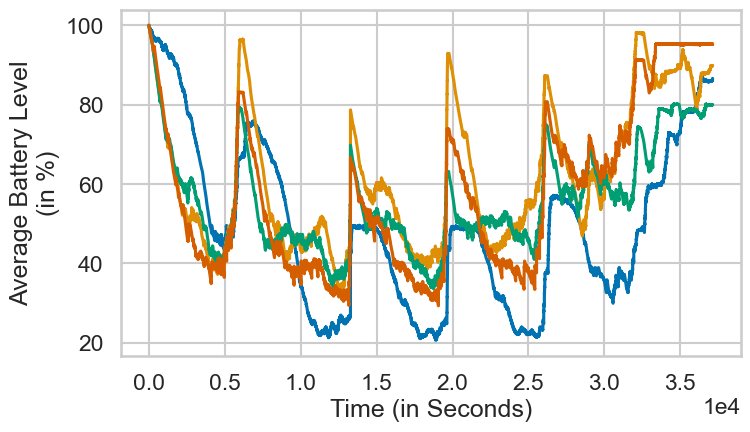

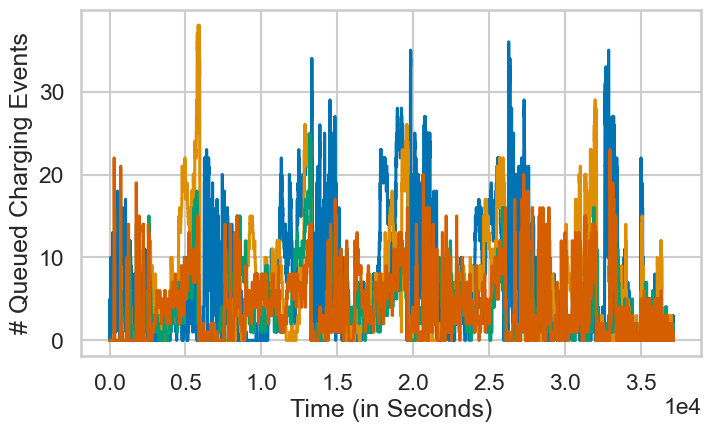

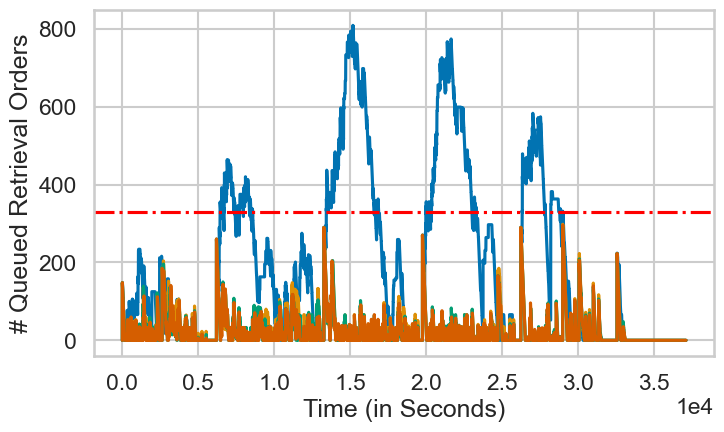

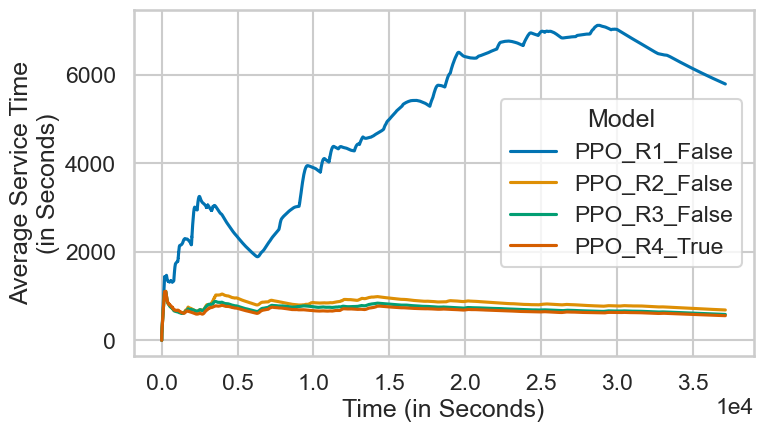

In [40]:
from copy import deepcopy

def plot_constraints(indicator, limit, df, hide_legend=False):
    _, ax = plt.subplots(figsize=(8, 4.5))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    
    palette = cycle(pal)
    xlim = 0
    # for th in reversed(list(dfs_d.keys())):
    #     for df in dfs_d[th]:
    #         if df.strategy_name[0] == "COL":
    #             df_parametrization_check = deepcopy(df)
    #             samples = df_parametrization_check.sample(min(500,df_parametrization_check.shape[0]))
    #             #if n_agv == 7:
    #             #    xlim = df_parametrization_check['kpi__makespan'].max() 
    #             #    print(xlim)
    #             ax = sns.lineplot(
    #                 ax=ax, x=samples['kpi__makespan'], y=samples[indicator], 
    #                 label=th, color=next(palette))
    
    
    ax = sns.lineplot(
                    ax=ax, x=df.index, y=df[indicator], hue=df["strategy_name"], palette=cycle(pal))
    if limit:
        ax.axhline(limit, 
                   color='red', linestyle='dashdot', label='Limit') 

    if not hide_legend:
        ax.legend(title='Model')
    else:
        ax.get_legend().remove()
    #ax.set_xlim((-5000, xlim + 20000))
    ax.set_xlabel('Time (in Seconds)')
    if indicator == "avg_battery_level":
        ax.set_ylabel('Average Battery Level\n(in %)')
    elif indicator == "kpi__average_service_time":
         ax.set_ylabel('Average Service Time\n(in Seconds)')
    else:
        new_indicator = indicator.replace("_", " ").title()
        if new_indicator[0].lower() == "n":
            new_indicator = "#" + new_indicator[1:]
        ax.set_ylabel(new_indicator)
    
    plt.savefig(f'{root_dir}/constraints__{indicator}.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

plot_constraints('avg_battery_level', limit=None, df=df_vis, hide_legend=True)
plot_constraints('n_queued_charging_events', limit=None, df=df_vis, hide_legend=True)
plot_constraints('n_queued_retrieval_orders', limit=330, df=df_vis, hide_legend=True)
plot_constraints('kpi__average_service_time', limit=None, df=df_vis)

# plot_constraints('n_queued_delivery_orders', limit=693)
# plot_constraints('avg_battery_level', limit=100)

In [238]:
dfs_d[0][0]

total_distance  average_distance  travel_time_retrieval_ave  \
0             165.0         23.571429                          0   
1             258.8         32.350000                          0   
2             352.6         39.177778                          0   
3             470.6         42.781818                          0   
4             760.4         50.693333                          0   
..              ...               ...                        ...   
591        113169.8         63.757634                          0   
592        113355.4         63.754443                          0   
593        113563.6         63.763953                          0   
594        113668.0         63.750981                          0   
595        114048.2         63.821041                          0   

     distance_retrieval_ave  total_shift_distance  utilization_time  \
0                         0                     0          0.000029   
1                         0                     0          0.000058   
2                         0                     0          0.000086   
3                         0                     0          0.000115   
4                         0                     0          0.000147   
..                      ...                   ...               ...   
591                       0                     0          0.015687   
592                       0                     0          0.015695   
593                       0                     0          0.015702   
594                       0                     0          0.015710   
595                       0                     0          0.015718   

     n_queued_retrieval_orders  n_queued_delivery_orders  n_finished_orders  \
0                            0                         0                  1   
1                            0                         0                  2   
2                            0                         0                  3   
3                            0                         0                  4   
4                            0                         0                  5   
..                         ...                       ...                ...   
591                          0                         0                592   
592                          0                         0                593   
593                          0                         0                594   
594                          0                         0                595   
595                          0                         0                596   

     kpi__throughput  ...   entropy  n_queued_charging_events  \
0           0.000012  ...  0.132465                         0   
1           0.000023  ...  0.132792                         0   
2           0.000035  ...  0.133118                         0   
3           0.000046  ...  0.133360                         0   
4           0.000058  ...  0.133601                         0   
..               ...  ...       ...                       ...   
591         0.005707  ...  0.135787                         0   
592         0.005710  ...  0.135804                         0   
593         0.005713  ...  0.135812                         0   
594         0.005717  ...  0.135812                         0   
595         0.005719  ...  0.135804                         1   

     avg_battery_level  n_agv_depleted  n_agv_not_depleted  n_charging_events  \
0            99.976162               0                  40                  0   
1            99.959148               0                  40                  0   
2            99.942134               0                  40                  0   
3            99.922690               0                  40                  0   
4            99.887821               0                  40                  0   
..                 ...             ...                 ...                ...   
591          84.606918               0

In [228]:
df_paper[df_paper["week"]==2]

total_distance  total_shift_distance  distance_retrieval_ave  \
0       167.083570              445412.8              183.852503   
1       173.066160              443598.4              187.111478   
2       173.066160              443598.4              187.111478   
3       167.870015              440563.2              184.876003   
5       158.464700              436993.2              183.442215   
7       158.958585              439874.4              184.161415   
8       158.545960              435705.2              184.015628   
14      159.200270              437819.2              184.497191   
15      157.927330              442682.8              182.665033   
17      159.149550              433759.2              184.325546   
19      157.898205              439454.4              183.268674   
20      157.836250              438404.4              184.401526   
22      156.844990              444122.0              182.958664   
23      158.037595              432762.4              184.805849   
24      158.071180              444525.2              183.562837   
27      157.181725              433980.4              184.381100   
29      172.934425              433230.0              186.700763   
35      156.882610              439353.6              183.344619   
38      160.019000              438877.6              184.861750   
42      171.394060              437250.8              189.175113   
48      165.437530              435593.2              188.650722   
51      168.318000              437810.8              186.560640   

    utilization_time   makespan     cycle_time   entropy  \
0           0.146588  1369943.6  631588.358448  0.974897   
1           0.146750  1369930.3  616887.078179  0.980227   
2           0.146750  1369930.3  616887.078179  0.980227   
3           0.146323  1369938.7  624535.090593  1.008621   
5           0.145130  1369939.4  612735.076247  0.972949   
7           0.145802  1369931.0  628525.478624  0.986901   
8           0.145017  1369930.3  629767.706011  0.989180   
14          0.145792  1369928.9  638498.643335  0.988824   
15          0.145606  1369940.1  639239.817361  0.991693   
17          0.145235  1369933.1  618731.878811  0.975223   
19          0.145170  1369932.4  647964.653593  1.001311   
20          0.145361  1369930.3  614311.747753  0.990548   
22          0.145852  1369933.8  627034.332781  0.990612   
23          0.145096  1369938.0  624912.337675  0.985775   
24          0.145830  1369928.9  627480.520402  1.010468   
27          0.144911  1369944.3  632994.142256  0.992518   
29          0.145650  1369936.6  627524.502492  0.999740   
35          0.145407  1369935.9  627645.445896  0.988358   
38          0.145550  1369940.8  649727.660169  1.001330   
42          0.147429  1369938.0  628279.164472  1.000316   
48          0.146248  1369938.0  624943.051305  1.025733   
51          0.146357  1369931.0  625902.538774  1.017406   

    average_service_time  max_average_service_time  throughput  ...  \
0             658.023305               2215.361866    0.025264  ...   
1             678.695591               2215.361866    0.025264  ...   
2             678.695591               2215.361866    0.025264  ...   
3             687.489292               2215.361866    0.025264  ...   
5             693.000335               2215.361866    0.025264  ...   
7             710.922372               2215.361866    0.025264  ...   
8             718.511737               2215.361866    0.025264  ...   
14            747.279845               2215.361866    0.025264  ...   
15            752.353499               2215.361866    0.025264  ...   
17            753.625146               2215.361866    0.025264  ...   
19            774.823620               2215.361866    0.025264  ...   
20            776.313776               2215.361866    0.025264  ...   
22            780.448897               2215.361866    0.025264  ...   
23            781.123256               2215.361866    0.025264  

In [229]:
battery_df

mean_battery_level reward_setting  week
0             99.063120             R4    13
1             98.995900             R4    13
2             97.704340             R4    13
3             94.196304             R4    13
4             94.085430             R4    13
..                  ...            ...   ...
495           53.110405             R4    13
496           65.129610             R4    13
497           64.925440             R4    13
498           64.720150             R4    13
499           64.600780             R4    13

[500 rows x 3 columns]

In [57]:
battery_df[battery_df["reward_setting"]=="R5"]

mean_battery_level reward_setting  week
0             98.818660             R5    13
1             98.469406             R5    13
2             98.407800             R5    13
3             96.850370             R5    13
4             93.302320             R5    13
..                  ...            ...   ...
495           61.180088             R5    13
496           66.806410             R5    13
497           65.737900             R5    13
498           65.493720             R5    13
499           64.558426             R5    13

[500 rows x 3 columns]

In [58]:
dfs_d

{0: [     total_distance  average_distance  travel_time_retrieval_ave  \
  0             165.0         23.571429                          0   
  1             258.8         32.350000                          0   
  2             352.6         39.177778                          0   
  3             470.6         42.781818                          0   
  4             760.4         50.693333                          0   
  ..              ...               ...                        ...   
  591        113169.8         63.757634                          0   
  592        113355.4         63.754443                          0   
  593        113563.6         63.763953                          0   
  594        113668.0         63.750981                          0   
  595        114048.2         63.821041                          0   
  
       distance_retrieval_ave  total_shift_distance  utilization_time  \
  0                         0                     0          0.000029   
  1     

In [27]:
layout = pd.read_csv(f"../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/1_layout.csv", header=None, delimiter=",")
layout.dropna(axis=1, how='all', inplace=True)

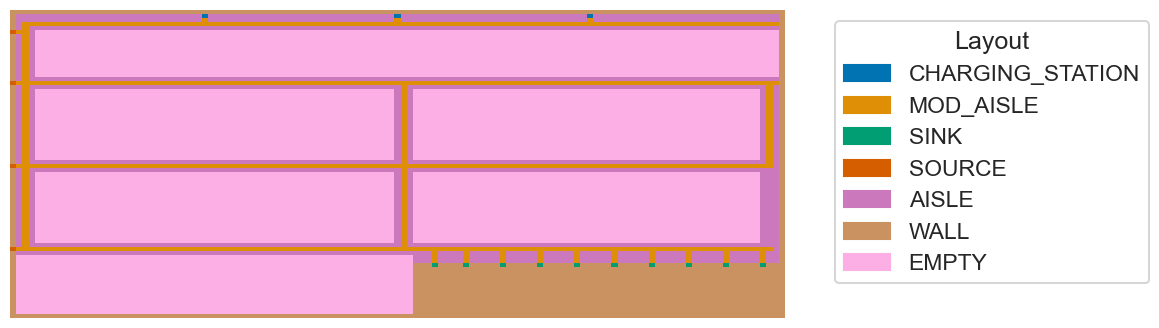

In [29]:
import matplotlib.patches as mpatches
# Create figure and axis
_, ax = plt.subplots(figsize=(10, 4))

# Get unique values, drop NaNs, and create a color mapping
unique_values = np.unique(layout)
unique_values = unique_values[~np.isnan(unique_values)]
palette_hm = sns.color_palette("colorblind", len(unique_values))
color_mapping = {val: palette_hm[i] for i, val in enumerate(unique_values)}
key_map = {0: "EMPTY", 
           -1: "WALL",
           -2: "AISLE",
           -3: "SOURCE",
           -4: "SINK",
           -5: "MOD_AISLE",
           -6: "CHARGING_STATION"}
# Create heatmap with cbar=False to remove the color bar
sns.heatmap(
    data=layout, 
    cmap=sns.color_palette(palette_hm, as_cmap=True), 
    cbar=False,  # Remove color bar
    ax=ax, 
    xticklabels=False,  # Disable x-axis labels
    yticklabels=False    # Disable y-axis labels
)

# Hide axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Create legend
legend_patches = [mpatches.Patch(color=color_mapping[val], label=key_map[val]) for val in unique_values]
ax.legend(handles=legend_patches, title="Layout", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(f'{root_dir}/warehouse_layout.png', 
                dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()